Differential NicheNet analysis between conditions of interest 
================ 
Robin Browaeys 
2022-01-12 
 
<!-- github markdown built using  
rmarkdown::render("vignettes/differential_nichenet_pcw.Rmd", output_format = "github_document") 
--> 
 
Remark: this is a beta version of a new extension of NicheNet, namely 
Differential NicheNet. Short-term improvements will include scalability, 
visualization and documentation of this vignette and the underlying 
functions (january 2022). 
 
The goal of Differential NicheNet is to predict ligand-receptors pairs 
that are both differentially expressed and active between different 
niches of interest. 
 
This vignette guides you in detail through all the steps of a 
Differential NicheNet analysis. As example expression data of 
interacting cells, we will use data from Puram et al. to explore 
intercellular communication in the tumor microenvironment in head and 
neck squamous cell carcinoma (HNSCC) (Puram et al. 2017). More 
specifically, we will look at cell-cell communication differences 
between pcw-high and pcw-low tumors (pcw = partial 
epithelial-mesenschymal transition). In this data, we thus have 2 
conditions/niches, but this pipeline is also usable for more 
conditions/niches. 
 
The used ligand-receptor network and ligand-target matrix can be 
downloaded from Zenodo 
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3260758.svg)](https://doi.org/10.5281/zenodo.3260758). 
The Seurat object containing expression data of interacting cells in 
HNSCC can also be downloaded from Zenodo 
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4675430.svg)](https://doi.org/10.5281/zenodo.4675430). 
 
# 0. Read in the expression data of interest, and the NicheNet ligand-receptor network and ligand-target matrix 
 
## Load in packages 
 


In [1]:
library(nichenetr) 
library(RColorBrewer) 
library(tidyverse)
library(Seurat) # 


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Attaching SeuratObject



 
## Read in the expression data 
 
In this case study, we want to study differences in cell-cell 
communication patterns between pcw-high and pcw-low tumors. The meta 
data columns that indicate the pcw status of tumors are ‘pcw’, and the 
cell type is indicated in the ‘independent_annotation_refined_20220202’ column. 
 


In [4]:
seurat_obj = readRDS(file.path("~/FCA_Fetal_Skin_priv/", "data", "fetal_skin.norm.maternal_removed.20220202.rds")) 

In [5]:
seurat_obj@meta.data %>% head()

,sanger_id,chemistry,donor,gender,pcw,sorting,sample,chemistry_sorting,cell_caller,scrublet_score,⋯,independent_annotation_refined_20220201b,independent_annotation_broad1_20220201,independent_annotation_broad2_20220201,independent_annotation_broad3_20220201,joint_annotation_20220201a,joint_annotation_20220201b,fig1b_annotation_20220201,joint_annotation_20220202,independent_annotation_refined_20220202,fig1b_annotation_20220202
,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
AAACCTGGTCAGTGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.2258065,⋯,Macrophage,Macrophage,Macrophage,Macrophage,Macrophage1,Macrophage,Macrophage,LYVE1++ macrophage,LYVE1++ macrophage,Macrophage
AAAGATGGTCGATTGT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.1496063,⋯,Monocyte (activated/differentiating),Monocyte,Monocyte,Monocyte,Monocyte (activated/differentiating),Monocyte (activated/differentiating),Monocyte,Monocyte (activated/differentiating),Monocyte (activated/differentiating),Monocyte
AAAGCAAAGATGTGGC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.2019704,⋯,Macrophage,Macrophage,Macrophage,Macrophage,Macrophage1,Macrophage,Macrophage,LYVE1++ macrophage,LYVE1++ macrophage,Macrophage
AAAGTAGCAGATCGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.1645570,⋯,Eo/baso/mast cell progenitor,Granulocyte progenitor,Granulocyte progenitor,Granulocyte progenitor,Eo/baso/mast cell progenitor,Eo/baso/mast cell progenitor,Progenitor,Eo/baso/mast cell progenitor,Eo/baso/mast cell progenitor,Progenitor
AAAGTAGTCCGCATCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.1818182,⋯,Macrophage,Macrophage,Macrophage,Macrophage,Macrophage1,Macrophage,Macrophage,LYVE1++ macrophage,LYVE1++ macrophage,Macrophage
AAATGCCAGCTGCCCA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.2544379,⋯,Macrophage,Macrophage,Macrophage,Macrophage,Macrophage1,Macrophage,Macrophage,LYVE1++ macrophage,LYVE1++ macrophage,Macrophage


In [10]:
seurat_obj@reductions

$umap1
A dimensional reduction object with key UMAP1_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 

$umap2
A dimensional reduction object with key UMAP2_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



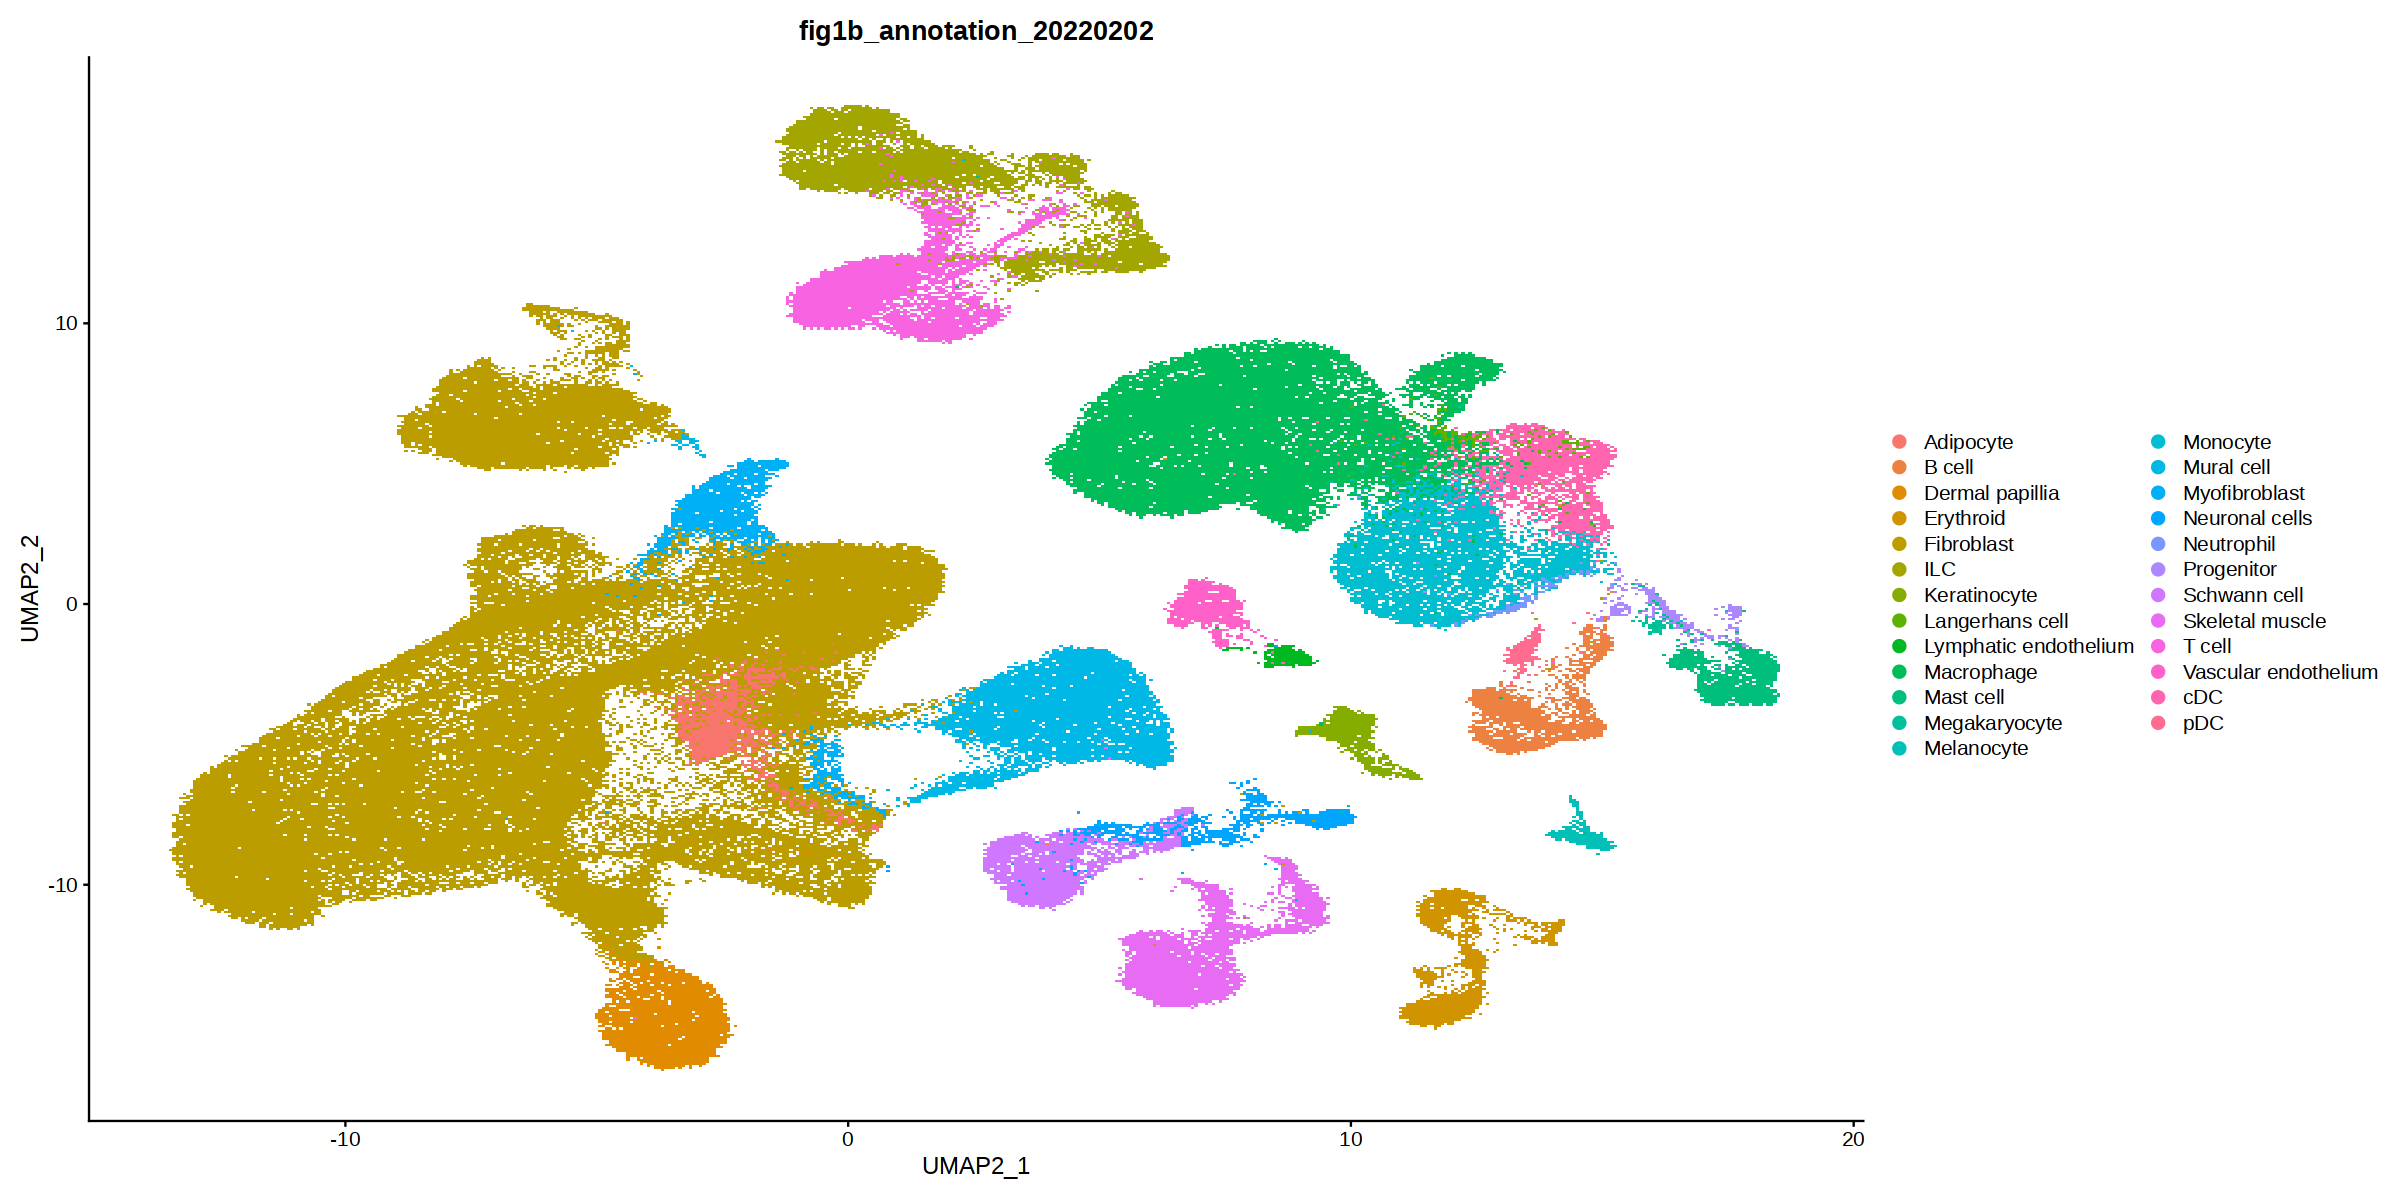

In [13]:
options(repr.plot.width=20, repr.plot.height=10)
DimPlot(seurat_obj, group.by = "fig1b_annotation_20220202", reduction = "umap2") # user adaptation required on own pcw 

 
![](differential_nichenet_pcw_files/figure-gfm/unnamed-chunk-2-1.png)<!-- --> 
 


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



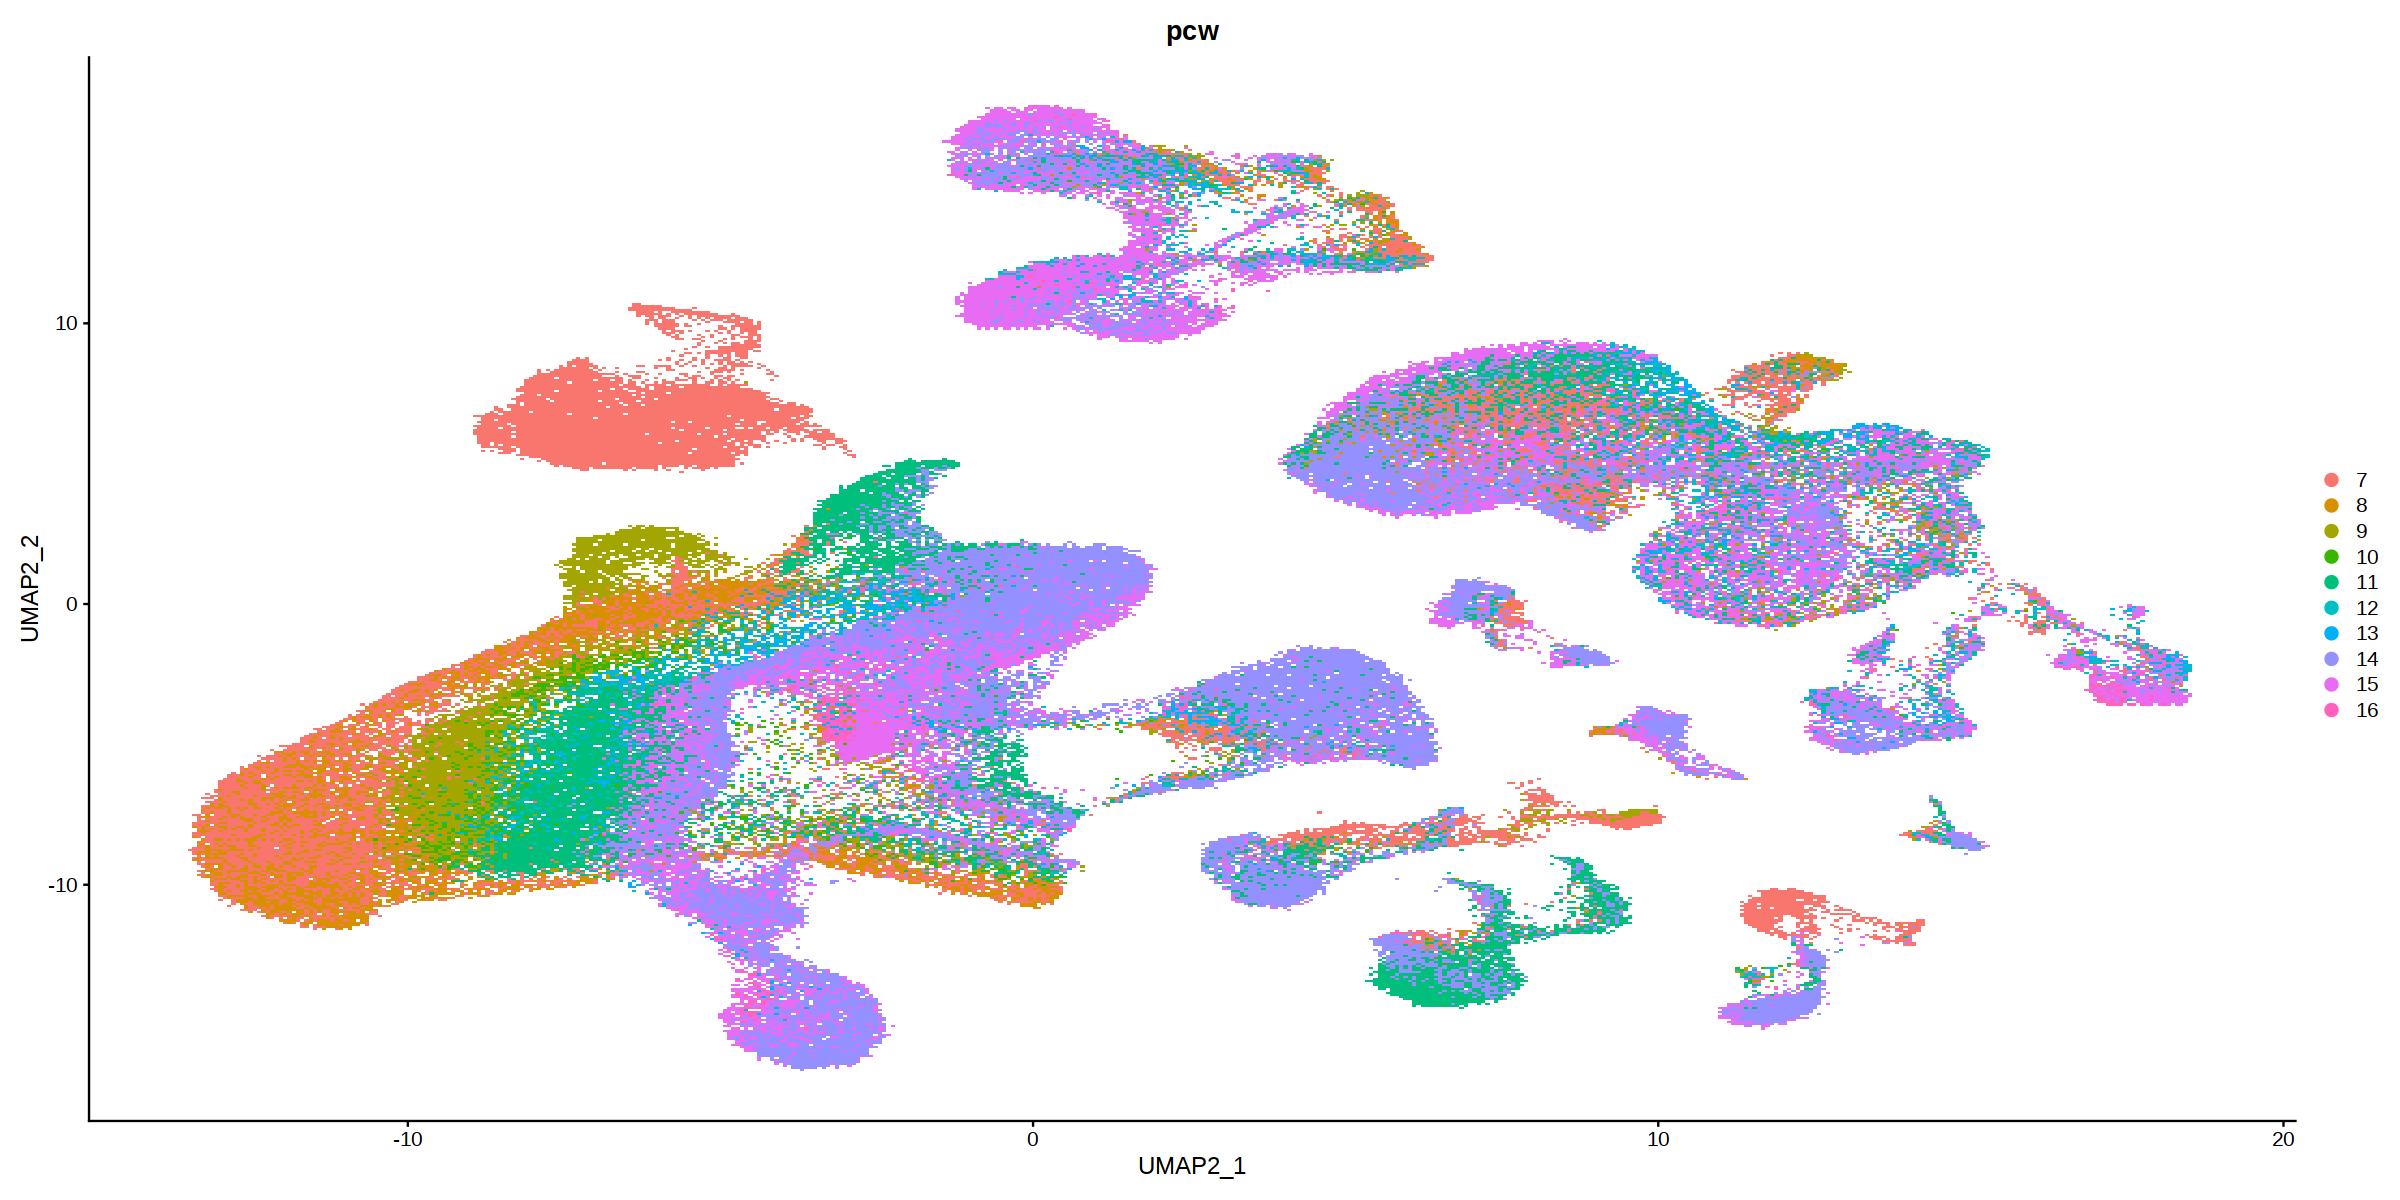

In [14]:
DimPlot(seurat_obj, group.by = "pcw", reduction = "umap2") # user adaptation required on own pcw 


 
![](differential_nichenet_pcw_files/figure-gfm/unnamed-chunk-2-2.png)<!-- --> 
 
We will now also check the number of cells per cell type condition 
combination 
 


In [16]:
table(seurat_obj@meta.data$independent_annotation_refined_20220202, seurat_obj@meta.data$pcw) # cell types vs conditions # user adaptation required on own pcw 
##                 
##                 High  Low 
##   CAF            396  104 
##   Endothelial    105   53 
##   Malignant     1093  549 
##   Myeloid         92    7 
##   myofibroblast  382   61 
##   T.cell         689    3 


                                       
                                            7     8     9    10    11    12
  ASDC                                      2     2     7     0     7    21
  Iron-recycling macrophage                64    30    15     1    11    14
  Adipocytes                                0     0     2     0     2    64
  Arterial                                 27     1     3     0    10     5
  B cell                                    3     2    18     6    46   321
  Basal KC                                  0     0     0     0     0     0
  CD4 T cell                               18    10    42     2    33  1031
  CD8 T cell                                0     6     7     0     4   193
  Capillary (venular tip)                  32    11    24     6    65    19
  Capillary/postcapillary venule            6     0    10     9    39    18
  DC1                                      49     9    74     1    47   223
  DC2                                     259   

 
For the Differential NicheNet, we need to compare at least 2 niches or 
conditions to each other. In this case, the 2 niches are the 
pcw-high-niche and the pcw-low-niche. We will adapt the names of the 
cell types based on their niche of origin. 
 


In [17]:
as.vector(seurat_obj@meta.data$independent_annotation_refined_20220202) %>% head()

[1] "LYVE1++ macrophage"                  
[2] "Monocyte (activated/differentiating)"
[3] "LYVE1++ macrophage"                  
[4] "Eo/baso/mast cell progenitor"        
[5] "LYVE1++ macrophage"                  
[6] "LYVE1++ macrophage"

In [18]:
seurat_obj@meta.data$independent_annotation_refined_20220202_aggregate = paste(seurat_obj@meta.data$independent_annotation_refined_20220202, seurat_obj@meta.data$pcw,sep = "_") # user adaptation required on own dataset 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



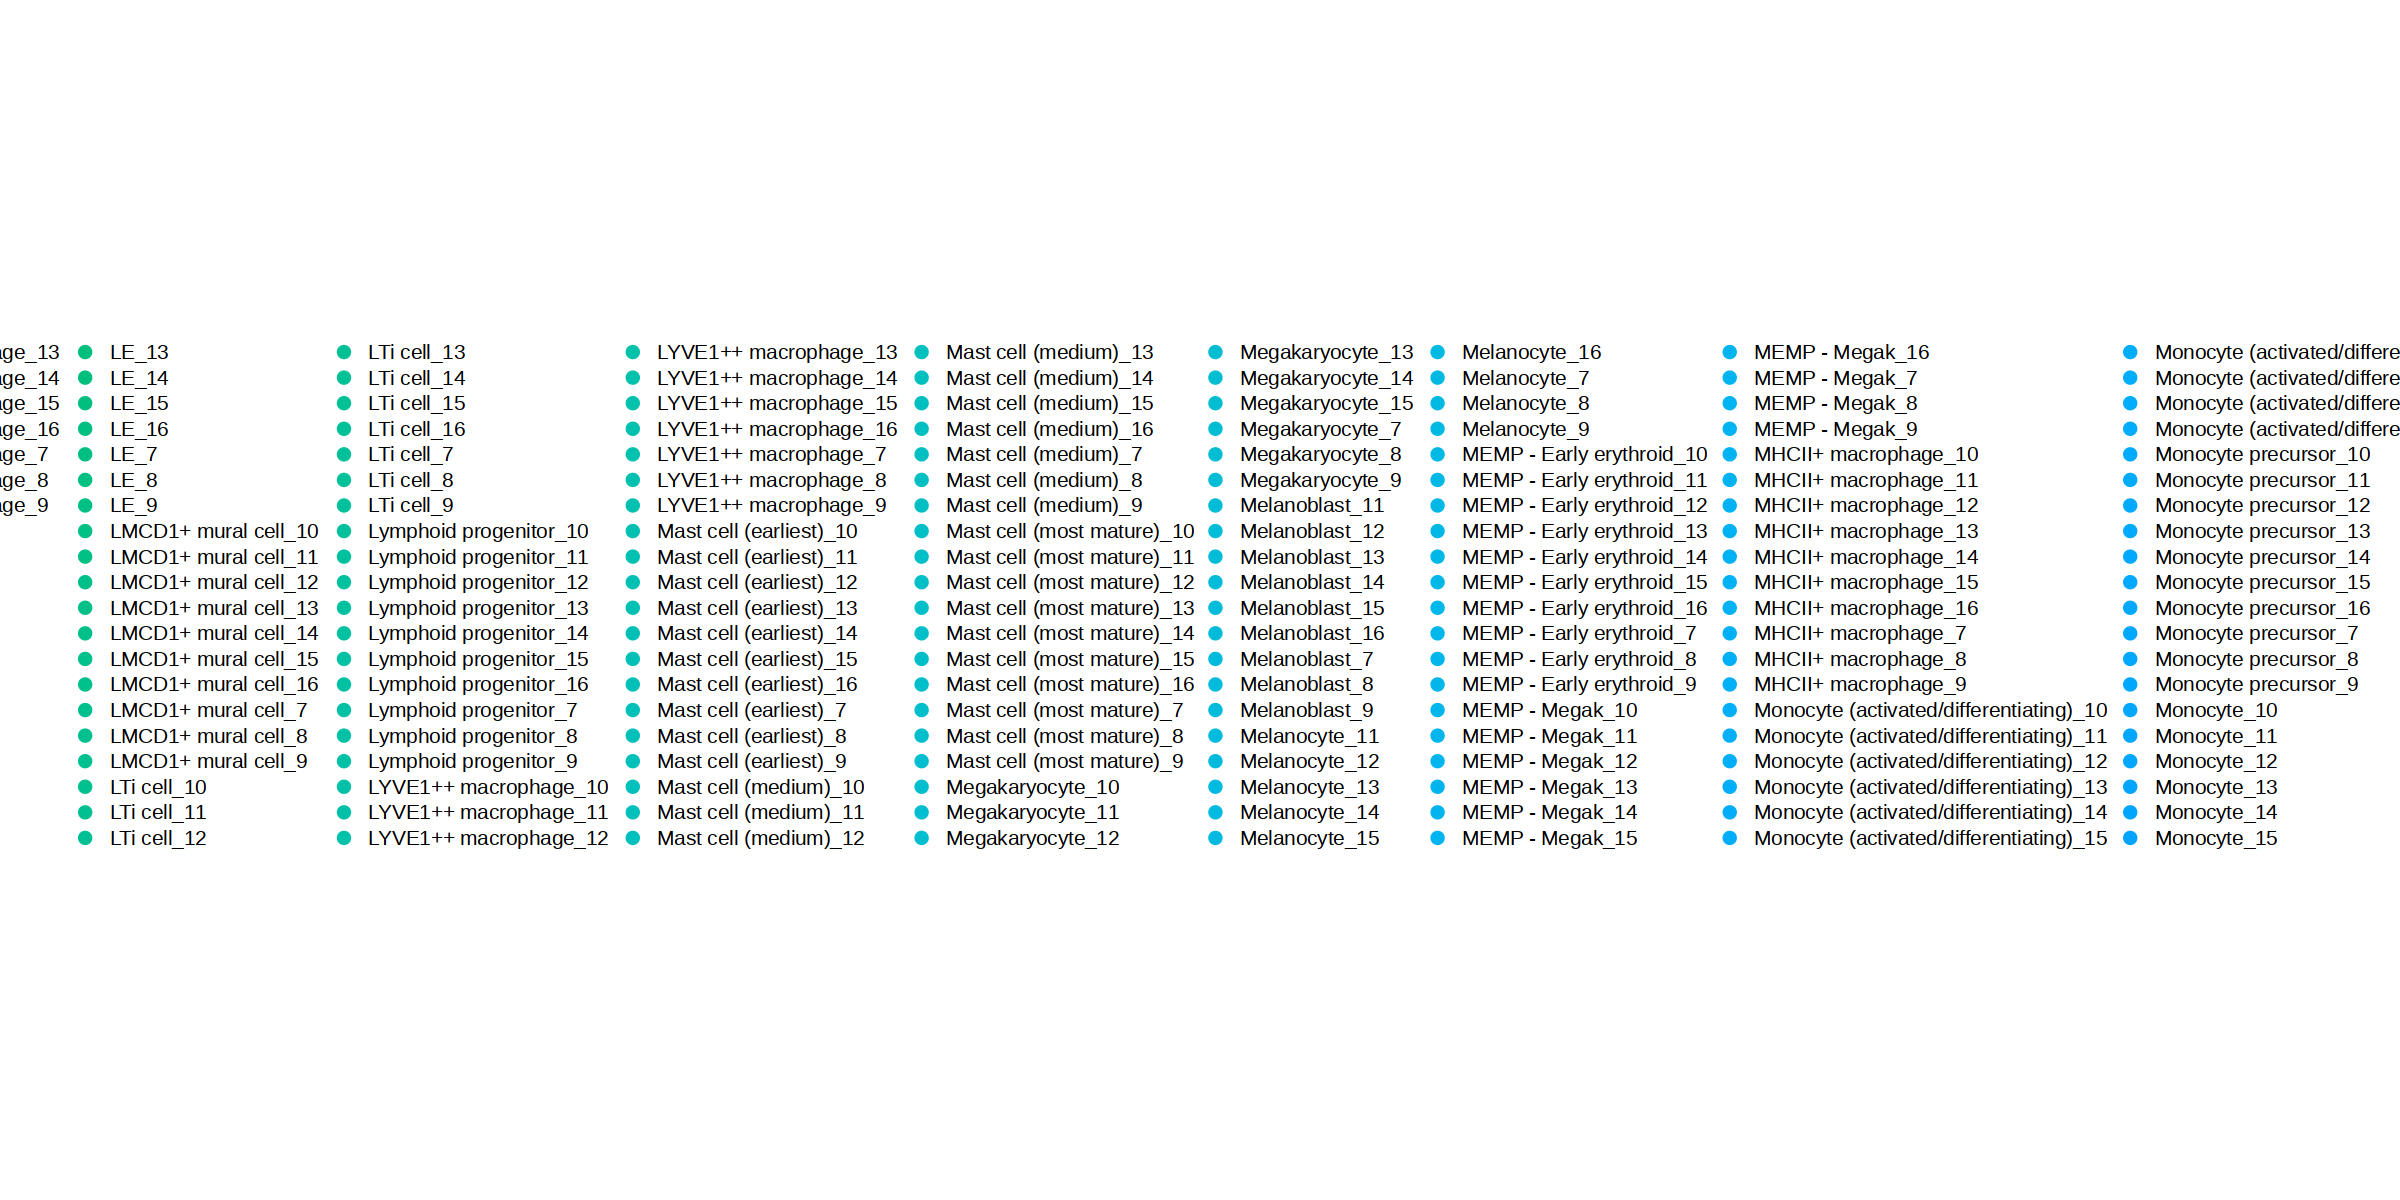

In [19]:
options(repr.plot.width=20, repr.plot.height=10)
DimPlot(seurat_obj, group.by = "independent_annotation_refined_20220202_aggregate", reduction = "umap2") 

 
![](differential_nichenet_pcw_files/figure-gfm/unnamed-chunk-4-1.png)<!-- --> 
 


In [42]:
# seurat_obj@meta.data$independent_annotation_refined_20220202 = unlist(strsplit(as.vector(seurat_obj@meta.data$independent_annotation_refined_20220202), split="_"))[2*(1:length(as.vector(seurat_obj@meta.data$independent_annotation_refined_20220202)))]

In [108]:
receiver_patts= c("Arterial", "Capillary", "venular", "Capillary", "postcapillary", "venule", 
                  "Early endothelial cell", "Tip cell")

In [109]:
paste(receiver_patts,collapse = "|")

[1] "Arterial|Capillary|venular|Capillary|postcapillary|venule|Early endothelial cell|Tip cell"

In [112]:
sender_papillia = unique(seurat_obj$independent_annotation_refined_20220202_aggregate[grepl("papillia", seurat_obj$independent_annotation_refined_20220202)])
sender_macs = unique(seurat_obj$independent_annotation_refined_20220202_aggregate[grepl("macrophage", seurat_obj$independent_annotation_refined_20220202)])
sender_fetal = c(as.vector(sender_papillia[grepl("fetal", sender_papillia)]), as.vector(sender_macs[grepl("fetal", sender_macs)]))
sender_org = c(as.vector(sender_papillia[grepl("organoid", sender_papillia)]), as.vector(sender_macs[grepl("organoid", sender_macs)]))
receivers = unique(seurat_obj$independent_annotation_refined_20220202_aggregate[grepl(paste(receiver_patts, collapse="|"), seurat_obj$independent_annotation_refined_20220202, ignore.case = TRUE)])
receivers_fetal = as.vector(receivers[grepl("fetal", receivers)])
receivers_organoid = as.vector(receivers[grepl("organoid", receivers)])

In [195]:
as.vector(sender_macs)

[1] "fetal_LYVE1++ macrophage"        "fetal_TREM2+ macrophage"        
[3] "fetal_Iron-recycling macrophage" "fetal_MHCII+ macrophage"

In [123]:
sender_fetal
sender_org
receivers_fetal
receivers_organoid

[1] "fetal_Dermal papillia"           "fetal_LYVE1++ macrophage"       
[3] "fetal_TREM2+ macrophage"         "fetal_Iron-recycling macrophage"
[5] "fetal_MHCII+ macrophage"

[1] "organoid_Dermal papillia"

[1] "fetal_Capillary (venular tip)"       
[2] "fetal_Tip cell (arterial)"           
[3] "fetal_Capillary/postcapillary venule"
[4] "fetal_Early endothelial cell"        
[5] "fetal_Arterial"                      
[6] "fetal_Postcapillary venule"

[1] "organoid_Tip cell (arterial)"

In [134]:
seurat_obj@meta.data = seurat_obj@meta.data %>% mutate(independent_annotation_refined_20220202_aggregate = recode(independent_annotation_refined_20220202_aggregate, 
                                                                                       'fetal_Capillary (venular tip)' = "receivers_fetal", 
                                                                                       'fetal_Tip cell (arterial)' = "receivers_fetal", 
                                                                                       'fetal_Capillary/postcapillary venule' = "receivers_fetal", 
                                                                                       'fetal_Early endothelial cell' = "receivers_fetal", 
                                                                                       'fetal_Arterial' = "receivers_fetal", 
                                                                                       'fetal_Postcapillary venule' = "receivers_fetal", 
                                                                                       'organoid_Tip cell (arterial)' = "receivers_organoid"))

In [20]:
seurat_obj@meta.data$independent_annotation_refined_20220202_aggregate %>% table() %>% sort(decreasing = TRUE) 
## . 
##     Malignant_High        T.cell_High      Malignant_Low           CAF_High myofibroblast_High   Endothelial_High            CAF_Low  
##               1093                689                549                396                382                105                104  
##       Myeloid_High  myofibroblast_Low    Endothelial_Low        Myeloid_Low         T.cell_Low  
##                 92                 61                 53                  7                  3 

.
                FRZB+ early fibroblast_7 
                                   10783 
               HOXC5+ early fibroblast_7 
                                    8084 
               HOXC5+ early fibroblast_8 
                                    6993 
                     WNT2+ fibroblast_15 
                                    6810 
                     WNT2+ fibroblast_14 
                                    5426 
                 Pre-dermal condensate_9 
                                    5068 
                   LYVE1++ macrophage_15 
                                    4922 
                Pre-dermal condensate_11 
                                    4515 
                    LYVE1++ macrophage_7 
                                    4058 
                      WNT2+ fibroblast_9 
                                    4031 
                            Myoblasts_11 
                                    3789 
                Pre-dermal condensate_15 
                                

In [184]:
Idents(seurat_obj)[grepl("seurat", Idents(seurat_obj), ignore.case = TRUE)]

factor(0)
112 Levels: fetal_ASDC fetal_Adipocytes receivers_fetal ... organoid_Uncertain

In [21]:
independent_annotation_refined_20220202_id = "independent_annotation_refined_20220202_aggregate" # metadata column name of the cell type of interest 
seurat_obj = SetIdent(seurat_obj, value = seurat_obj[[independent_annotation_refined_20220202_id]]) 


 
## Read in the NicheNet ligand-receptor network and ligand-target matrix 
 


In [22]:
ligand_target_matrix = readRDS(file.path("~/FCA_Fetal_Skin_priv/data/ligand_target_matrix.rds")) 
ligand_target_matrix[1:5,1:5] # target genes in rows, ligands in columns 
##                 CXCL1        CXCL2        CXCL3        CXCL5         PPBP 
## A1BG     3.534343e-04 4.041324e-04 3.729920e-04 3.080640e-04 2.628388e-04 
## A1BG-AS1 1.650894e-04 1.509213e-04 1.583594e-04 1.317253e-04 1.231819e-04 
## A1CF     5.787175e-04 4.596295e-04 3.895907e-04 3.293275e-04 3.211944e-04 
## A2M      6.027058e-04 5.996617e-04 5.164365e-04 4.517236e-04 4.590521e-04 
## A2M-AS1  8.898724e-05 8.243341e-05 7.484018e-05 4.912514e-05 5.120439e-05 


,CXCL1,CXCL2,CXCL3,CXCL5,PPBP
A1BG,3.534343e-04,4.041324e-04,3.729920e-04,3.080640e-04,2.628388e-04
A1BG-AS1,1.650894e-04,1.509213e-04,1.583594e-04,1.317253e-04,1.231819e-04
A1CF,5.787175e-04,4.596295e-04,3.895907e-04,3.293275e-04,3.211944e-04
A2M,6.027058e-04,5.996617e-04,5.164365e-04,4.517236e-04,4.590521e-04
A2M-AS1,8.898724e-05,8.243341e-05,7.484018e-05,4.912514e-05,5.120439e-05


In [23]:
lr_network = readRDS(file.path("~/FCA_Fetal_Skin_priv/data/lr_network.rds")) 
lr_network = lr_network %>% mutate(bonafide = ! database %in% c("ppi_prediction","ppi_prediction_go")) 
lr_network = lr_network %>% dplyr::rename(ligand = from, receptor = to) %>% distinct(ligand, receptor, bonafide) 
 
head(lr_network) 
## # A tibble: 6 x 3 
##   ligand receptor bonafide 
##   <chr>  <chr>    <lgl>    
## 1 CXCL1  CXCR2    TRUE     
## 2 CXCL2  CXCR2    TRUE     
## 3 CXCL3  CXCR2    TRUE     
## 4 CXCL5  CXCR2    TRUE     
## 5 PPBP   CXCR2    TRUE     
## 6 CXCL6  CXCR2    TRUE 


ligand,receptor,bonafide
<chr>,<chr>,<lgl>
CXCL1,CXCR2,TRUE
CXCL2,CXCR2,TRUE
CXCL3,CXCR2,TRUE
CXCL5,CXCR2,TRUE
PPBP,CXCR2,TRUE
CXCL6,CXCR2,TRUE


 
Note: if your data is of mouse origin: convert human gene symbols to 
their one-to-one orthologs 
 


In [24]:
organism = "human" # user adaptation required on own pcw 

In [ ]:
if(organism == "mouse"){ 
  lr_network = lr_network %>% mutate(ligand = convert_human_to_mouse_symbols(ligand), receptor = convert_human_to_mouse_symbols(receptor)) %>% drop_na() 
 
  colnames(ligand_target_matrix) = ligand_target_matrix %>% colnames() %>% convert_human_to_mouse_symbols() 
  rownames(ligand_target_matrix) = ligand_target_matrix %>% rownames() %>% convert_human_to_mouse_symbols() 
  ligand_target_matrix = ligand_target_matrix %>% .[!is.na(rownames(ligand_target_matrix)), !is.na(colnames(ligand_target_matrix))] 
} 


 
# 1. Define the niches/microenvironments of interest 
 
Each niche should have at least one “sender/niche” cell population and 
one “receiver/target” cell population (present in your expression data) 
 
In this case study, we are interested to find differences in cell-cell 
interactions to malignant cells between pcw high and pcw low tumors. 
The receiver cell population in the pcw-High niche is thus the 
“Malignant_High” cell type, and in the pcw-Low niche this is 
“Malignant_Low”. The sender cell populations of interest are 
myofibroblasts, Endothelial, CAF, T.cell, and Myeloid. Importantly, we 
only include T.Cell and Myeloid in the pcw-High niche, because there 
are too few cells of these populations present in the pcw-low niche. 
Hereby, we demonstrate the possibility to include a condition-specific 
cell type in the analysis - which is possible because we calculate DE 
compared to all sender cells of the other niche, and not only to the 
pcw-low group of cells of the same cell type. 
 
! Important: your receiver cell type should consist of 1 cluster! 
 


In [168]:
length(seurat_obj@meta.data$independent_annotation_refined_20220202_aggregate[grepl("receivers_organoid", seurat_obj@meta.data$independent_annotation_refined_20220202_aggregate)])

[1] 130

In [25]:
unique(seurat_obj@meta.data$pcw)

[1]  8  9 10  7 12 16 13 15 11 14

In [186]:
niches = list( 
  "pcw_High_niche" = list( 
    "sender" = sender_fetal, 
    "receiver" = c("receivers_fetal")), 
  "pcw_Low_niche" = list( 
    "sender" = sender_org, 
    "receiver" = c("receivers_organoid")), 
  "pcw_High_niche" = list( 
    "sender" = sender_fetal, 
    "receiver" = c("receivers_fetal")), 
  "pcw_Low_niche" = list( 
    "sender" = sender_org, 
    "receiver" = c("receivers_organoid")), 
  "pcw_High_niche" = list( 
    "sender" = sender_fetal, 
    "receiver" = c("receivers_fetal")), 
  "pcw_Low_niche" = list( 
    "sender" = sender_org, 
    "receiver" = c("receivers_organoid")), 
  "pcw_High_niche" = list( 
    "sender" = sender_fetal, 
    "receiver" = c("receivers_fetal")), 
  "pcw_Low_niche" = list( 
    "sender" = sender_org, 
    "receiver" = c("receivers_organoid")), 
  "pcw_High_niche" = list( 
    "sender" = sender_fetal, 
    "receiver" = c("receivers_fetal")), 
  "pcw_Low_niche" = list( 
    "sender" = sender_org, 
    "receiver" = c("receivers_organoid")) 
  ) # user adaptation required on own pcw 


In [170]:
seurat_obj

An object of class Seurat 
26721 features across 310368 samples within 1 assay 
Active assay: RNA (26721 features, 0 variable features)

 
# 2. Calculate differential expression between the niches 
 
In this step, we will determine DE between the different niches for both 
senders and receivers to define the DE of L-R pairs. 
 
### Calculate DE 
 
The method to calculate the differential expression is here the standard 
Seurat Wilcoxon test, but this can be replaced if wanted by the user 
(only requirement: output tables `DE_sender_processed` and 
`DE_receiver_processed` should be in the same format as shown here). 
 
DE will be calculated for each pairwise sender (or receiver) cell type 
comparision between the niches (so across niches, not within niche). In 
our case study, this means that DE of myofibroblast_High ligands will be 
calculated by DE analysis of myofibroblast_High vs myofibroblast_Low; 
myofibroblast_High vs Endothelial_Low; and myofibroblast_High vs 
CAF_Low. We split the cells per cell type instead of merging all cells 
from the other niche to avoid that the DE analysis will be driven by the 
most abundant cell types. 
 


In [172]:
Idents(seurat_obj) %>% table()

.
                                    fetal_ASDC 
                                            90 
                              fetal_Adipocytes 
                                          3203 
                               receivers_fetal 
                                          1591 
                                  fetal_B cell 
                                          1982 
                                   fetal_Basal 
                                           815 
                              fetal_CD4 T cell 
                                          4675 
                              fetal_CD8 T cell 
                                          1519 
                         fetal_Companion layer 
                                            27 
                          fetal_Cuticle/cortex 
                                            21 
                                     fetal_DC1 
                                           748 
                                     f

In [171]:
assay_oi = "RNA" # other possibilities: RNA,... 
DE_sender = calculate_niche_de(seurat_obj = seurat_obj %>% subset(features = lr_network$ligand %>% unique()), niches = niches, type = "sender", assay_oi = assay_oi) # only ligands important for sender cell types 
## [1] "Calculate Sender DE between: myofibroblast_High and myofibroblast_Low" 
## [2] "Calculate Sender DE between: myofibroblast_High and Endothelial_Low"   
## [3] "Calculate Sender DE between: myofibroblast_High and CAF_Low"           
## [1] "Calculate Sender DE between: Endothelial_High and myofibroblast_Low" 
## [2] "Calculate Sender DE between: Endothelial_High and Endothelial_Low"   
## [3] "Calculate Sender DE between: Endothelial_High and CAF_Low"           
## [1] "Calculate Sender DE between: CAF_High and myofibroblast_Low" "Calculate Sender DE between: CAF_High and Endothelial_Low"   
## [3] "Calculate Sender DE between: CAF_High and CAF_Low"           
## [1] "Calculate Sender DE between: T.cell_High and myofibroblast_Low" "Calculate Sender DE between: T.cell_High and Endothelial_Low"   
## [3] "Calculate Sender DE between: T.cell_High and CAF_Low"           
## [1] "Calculate Sender DE between: Myeloid_High and myofibroblast_Low" "Calculate Sender DE between: Myeloid_High and Endothelial_Low"   
## [3] "Calculate Sender DE between: Myeloid_High and CAF_Low"           
## [1] "Calculate Sender DE between: myofibroblast_Low and myofibroblast_High" 
## [2] "Calculate Sender DE between: myofibroblast_Low and Endothelial_High"   
## [3] "Calculate Sender DE between: myofibroblast_Low and CAF_High"           
## [4] "Calculate Sender DE between: myofibroblast_Low and T.cell_High"        
## [5] "Calculate Sender DE between: myofibroblast_Low and Myeloid_High"       
## [1] "Calculate Sender DE between: Endothelial_Low and myofibroblast_High" 
## [2] "Calculate Sender DE between: Endothelial_Low and Endothelial_High"   
## [3] "Calculate Sender DE between: Endothelial_Low and CAF_High"           
## [4] "Calculate Sender DE between: Endothelial_Low and T.cell_High"        
## [5] "Calculate Sender DE between: Endothelial_Low and Myeloid_High"       
## [1] "Calculate Sender DE between: CAF_Low and myofibroblast_High" "Calculate Sender DE between: CAF_Low and Endothelial_High"   
## [3] "Calculate Sender DE between: CAF_Low and CAF_High"           "Calculate Sender DE between: CAF_Low and T.cell_High"        
## [5] "Calculate Sender DE between: CAF_Low and Myeloid_High" 

In [188]:
DE_receiver = calculate_niche_de(seurat_obj = seurat_obj %>% subset(features = lr_network$receptor %>% unique()), niches = niches, type = "receiver", assay_oi = assay_oi) # only receptors now, later on: DE analysis to find targets 
## # A tibble: 1 x 2 
##   receiver       receiver_other_niche 
##   <chr>          <chr>                
## 1 Malignant_High Malignant_Low        
## [1] "Calculate receiver DE between: Malignant_High and Malignant_Low" 
## [1] "Calculate receiver DE between: Malignant_Low and Malignant_High" 
DE_sender = DE_sender %>% mutate(avg_log2FC = ifelse(avg_log2FC == Inf, max(avg_log2FC[is.finite(avg_log2FC)]), ifelse(avg_log2FC == -Inf, min(avg_log2FC[is.finite(avg_log2FC)]), avg_log2FC))) 
DE_receiver = DE_receiver %>% mutate(avg_log2FC = ifelse(avg_log2FC == Inf, max(avg_log2FC[is.finite(avg_log2FC)]), ifelse(avg_log2FC == -Inf, min(avg_log2FC[is.finite(avg_log2FC)]), avg_log2FC))) 

# A tibble: 1 × 2
  receiver        receiver_other_niche
  <chr>           <chr>               
1 receivers_fetal receivers_organoid  
[1] "Calculate receiver DE between: receivers_fetal and receivers_organoid"
[1] "Calculate receiver DE between: receivers_organoid and receivers_fetal"


 
### Process DE results: 
 


In [189]:
expression_pct = 0.10 
DE_sender_processed = process_niche_de(DE_table = DE_sender, niches = niches, expression_pct = expression_pct, type = "sender") 
DE_receiver_processed = process_niche_de(DE_table = DE_receiver, niches = niches, expression_pct = expression_pct, type = "receiver") 


 
### Combine sender-receiver DE based on L-R pairs: 
 
As mentioned above, DE of ligands from one sender cell type is 
determined be calculating DE between that cell type, and all the sender 
cell types of the other niche. To summarize the DE of ligands of that 
cell type we have several options: we could take the average LFC, but 
also the minimum LFC compared to the other niche. We recommend using the 
minimum LFC, because this is the strongest specificity measure of ligand 
expression, because a high min LFC means that a ligand is more strongly 
expressed in the cell type of niche 1 compared to all cell types of 
niche 2 (in contrast to a high average LFC, which does not exclude that 
one or more cell types in niche 2 also strongly express that ligand). 
 


In [190]:
specificity_score_LR_pairs = "min_lfc" 
DE_sender_receiver = combine_sender_receiver_de(DE_sender_processed, DE_receiver_processed, lr_network, specificity_score = specificity_score_LR_pairs) 


 
# 3. Optional: Calculate differential expression between the different spatial regions 
 
To improve the cell-cell interaction predictions, you can consider 
spatial information if possible and applicable. Spatial information can 
come from microscopy data, or from spatial transcriptomics data such as 
Visium. 
 
There are several ways to incorporate spatial information in the 
Differential NicheNet pipeline. First, you can only consider cell types 
as belonging to the same niche if they are in the same spatial location. 
Another way is including spatial differential expression of 
ligand-receptor pairs within one cell type in the prioritization 
framework. 
 
For example: We have a cell type X, located in regions A and B, and we 
want to study cell-cell communication in region A. We first add only 
independent_annotation_refined_20220202X of regionA in the niche definition, and then calculate DE 
between independent_annotation_refined_20220202X-regionA and independent_annotation_refined_20220202X-regionB to give higher 
prioritization weight to regionA-specific ligands. 
 
In this case study, our region of interest is the tumor leading edge, 
since Puram et al defined this region as important regarding the pcw 
process. Puram et al also defined CAFs as the fibroblasts that are close 
to leading edge, whereas the other fibroblasts (myofibroblasts) were not 
preferentially located in the tumor leading edge. We can thus now 
prioritize fibroblast ligands further by looking at ligands that are DE 
between leading-edge fibroblasts (=CAFs) and non-leading-edge 
fibroblasts (myofibroblasts). 
 
We do this as follows, by first defining a ‘spatial info’ dataframe. If 
no spatial information in your data: set the following two parameters to 
FALSE, and make a mock ‘spatial_info’ data frame. 
 


In [26]:
include_spatial_info_sender = FALSE # if not spatial info to include: put this to false # user adaptation required on own pcw 
include_spatial_info_receiver = FALSE # if spatial info to include: put this to true # user adaptation required on own pcw 


In [27]:
spatial_info = tibble(celltype_region_oi = as.vector(sender_macs), celltype_other_region = as.vector(sender_papillia)[1], niche =  "pcw_High_niche", celltype_type = "sender") # user adaptation required on own pcw 
specificity_score_spatial = "lfc" 

ERROR: Error in as.vector(sender_macs): object 'sender_macs' not found


In [ ]:
receiver_spatial_info = tibble(celltype_region_oi = as.vector(sender_macs), celltype_other_region = as.vector(sender_papillia)[1], niche =  "pcw_High_niche", celltype_type = "sender") # user adaptation required on own pcw 

In [208]:
spatial_info

celltype_region_oi,celltype_other_region,niche,celltype_type
<chr>,<chr>,<chr>,<chr>
fetal_LYVE1++ macrophage,fetal_Dermal papillia,dataset_High_niche,sender
fetal_TREM2+ macrophage,fetal_Dermal papillia,dataset_High_niche,sender
fetal_Iron-recycling macrophage,fetal_Dermal papillia,dataset_High_niche,sender
fetal_MHCII+ macrophage,fetal_Dermal papillia,dataset_High_niche,sender


In [199]:
# this is how this should be defined if you don't have spatial info 
# mock spatial info 
if(include_spatial_info_sender == FALSE & include_spatial_info_receiver == FALSE){ 
    spatial_info = tibble(independent_annotation_refined_20220202_region_oi = NA, independent_annotation_refined_20220202_other_region = NA) %>% mutate(niche =  niches %>% names() %>% head(1), independent_annotation_refined_20220202_type = "sender") 
}  


In [201]:
specificity_score_spatial

[1] "lfc"

In [210]:
if(include_spatial_info_sender == TRUE){ 
  sender_spatial_DE = calculate_spatial_DE(seurat_obj = seurat_obj %>% subset(features = lr_network$ligand %>% unique()), spatial_info = spatial_info %>% filter(celltype_type == "sender"), assay_oi = assay_oi) 
  sender_spatial_DE_processed = process_spatial_de(DE_table = sender_spatial_DE, type = "sender", lr_network = lr_network, expression_pct = expression_pct, specificity_score = specificity_score_spatial) 
 
  # add a neutral spatial score for sender independent_annotation_refined_20220202s in which the spatial is not known / not of importance 
  sender_spatial_DE_others = get_non_spatial_de(niches = niches, spatial_info = spatial_info, type = "sender", lr_network = lr_network) 
  sender_spatial_DE_processed = sender_spatial_DE_processed %>% bind_rows(sender_spatial_DE_others) 
 
  sender_spatial_DE_processed = sender_spatial_DE_processed %>% mutate(scaled_ligand_score_spatial = scale_quantile_adapted(ligand_score_spatial)) 
 
} else { 
  # # add a neutral spatial score for all sender independent_annotation_refined_20220202s (for none of them, spatial is relevant in this case) 
  sender_spatial_DE_processed = get_non_spatial_de(niches = niches, spatial_info = spatial_info, type = "sender", lr_network = lr_network) 
  sender_spatial_DE_processed = sender_spatial_DE_processed %>% mutate(scaled_ligand_score_spatial = scale_quantile_adapted(ligand_score_spatial))   
 
} 
## [1] "Calculate Spatial DE between: CAF_High and myofibroblast_High" 


[1] "Calculate Spatial DE between: fetal_LYVE1++ macrophage and fetal_Dermal papillia"
[1] "Calculate Spatial DE between: fetal_TREM2+ macrophage and fetal_Dermal papillia"
[1] "Calculate Spatial DE between: fetal_Iron-recycling macrophage and fetal_Dermal papillia"
[1] "Calculate Spatial DE between: fetal_MHCII+ macrophage and fetal_Dermal papillia"


In [246]:
sender_spatial_DE_processed

niche,sender,ligand,ligand_score_spatial,scaled_ligand_score_spatial
<chr>,<chr>,<chr>,<dbl>,<dbl>
dataset_High_niche,fetal_LYVE1++ macrophage,SPP1,Inf,NaN
dataset_High_niche,fetal_TREM2+ macrophage,SPP1,Inf,NaN
dataset_High_niche,fetal_TREM2+ macrophage,CCL4,Inf,NaN
dataset_High_niche,fetal_Iron-recycling macrophage,SPP1,Inf,NaN
dataset_High_niche,fetal_TREM2+ macrophage,CCL3,999.2265,0.001
dataset_High_niche,fetal_MHCII+ macrophage,CCL4,829.9876,0.001
dataset_High_niche,fetal_LYVE1++ macrophage,CCL4,826.8506,0.001
dataset_High_niche,fetal_MHCII+ macrophage,CCL3,694.3763,0.001
dataset_High_niche,fetal_MHCII+ macrophage,SPP1,640.9748,0.001


In [212]:
if(include_spatial_info_receiver == TRUE){ 
  receiver_spatial_DE = calculate_spatial_DE(seurat_obj = seurat_obj %>% subset(features = lr_network$receptor %>% unique()), spatial_info = spatial_info %>% filter(celltype_type == "receiver"), assay_oi = assay_oi) 
  receiver_spatial_DE_processed = process_spatial_de(DE_table = receiver_spatial_DE, type = "receiver", lr_network = lr_network, expression_pct = expression_pct, specificity_score = specificity_score_spatial) 
 
  # add a neutral spatial score for receiver independent_annotation_refined_20220202s in which the spatial is not known / not of importance 
  receiver_spatial_DE_others = get_non_spatial_de(niches = niches, spatial_info = spatial_info, type = "receiver", lr_network = lr_network) 
  receiver_spatial_DE_processed = receiver_spatial_DE_processed %>% bind_rows(receiver_spatial_DE_others) 
 
  receiver_spatial_DE_processed = receiver_spatial_DE_processed %>% mutate(scaled_receptor_score_spatial = scale_quantile_adapted(receptor_score_spatial)) 
 
} else { 
    # # add a neutral spatial score for all receiver independent_annotation_refined_20220202s (for none of them, spatial is relevant in this case) 
  receiver_spatial_DE_processed = get_non_spatial_de(niches = niches, spatial_info = spatial_info, type = "receiver", lr_network = lr_network) 
  receiver_spatial_DE_processed = receiver_spatial_DE_processed %>% mutate(scaled_receptor_score_spatial = scale_quantile_adapted(receptor_score_spatial)) 
} 


 
# 4. Calculate ligand activities and infer active ligand-target links 
 
In this step, we will predict ligand activities of each ligand for each 
of the receiver cell types across the different niches. This is similar 
to the ligand activity analysis done in the normal NicheNet pipeline. 
 
To calculate ligand activities, we first need to define a geneset of 
interest for each niche. In this case study, the geneset of interest for 
the pcw-high niche are the genes upregulated in pcw-high tumors 
compared to pcw-low tumors, and vice versa. 
 
Note that you can also define these geneset of interest in a different 
way! (eg pathway-based geneset etc) 
 
Ligand-target links are inferred in the same way as described in the 
basic NicheNet vignettes. 
 


In [217]:
niches[[1]]

$sender
[1] "fetal_Dermal papillia"           "fetal_LYVE1++ macrophage"       
[3] "fetal_TREM2+ macrophage"         "fetal_Iron-recycling macrophage"
[5] "fetal_MHCII+ macrophage"        

$receiver
[1] "receivers_fetal"

In [223]:
?calculate_niche_de_targets

calculate_niche_de_targets {nichenetr},R Documentation
seurat_obj,Seurat object
niches,"a list of lists/niches giving the name, senders and receiver celltypes for each nice. Sender and receiver cell types should be part of Idents(seurat_obj)."
expression_pct,input of 'min.pct' of 'Seurat::FindMarkers'
lfc_cutoff,input of 'logfc.threshold' of 'Seurat::FindMarkers'
assay_oi,"Which assay need to be used for DE calculation via 'FindMarkers'. Default SCT, alternatives: RNA."


In [224]:
?process_receiver_target_de

process_receiver_target_de {nichenetr},R Documentation
DE_receiver_targets,Output of 'calculate_niche_de' with 'type = receiver'
niches,"a list of lists/niches giving the name, senders and receiver celltypes for each nice. Sender and receiver cell types should be part of Idents(seurat_obj)."
expression_pct,Percentage of cells of a cell type having a non-zero expression value for a gene such that a gene can be considered expressed by that cell type.
specificity_score,"Defines which score will be used to prioritze ligand-receptor pairs and consider their differential expression. Default and recommended: ""min_lfc"". ""min_lfc"" looks at the minimal logFC of the ligand/receptor between the celltype of interest and all the other celltypes. Alternatives: ""mean_lfc"", ""min_score"", and ""mean_score"". Mean uses the average/mean instead of minimum. score is the product of the logFC and the ratio of fraction of expressing cells."


In [247]:
lfc_cutoff = 0.75 # recommended for 10x as min_lfc cutoff.
lfc_cutoff_low = 0.15
specificity_score_targets = "min_lfc" 
 
DE_receiver_targets = calculate_niche_de_targets(seurat_obj = seurat_obj, niches = niches, lfc_cutoff = lfc_cutoff_low, expression_pct = expression_pct, assay_oi = assay_oi)  
## [1] "Calculate receiver DE between: Malignant_High and Malignant_Low" 
## [1] "Calculate receiver DE between: Malignant_Low and Malignant_High" 
DE_receiver_processed_targets = process_receiver_target_de(DE_receiver_targets = DE_receiver_targets, niches = niches, expression_pct = expression_pct, specificity_score = specificity_score_targets) 
 
background = DE_receiver_processed_targets  %>% pull(target) %>% unique() 
geneset_niche1 = DE_receiver_processed_targets %>% filter(receiver == niches[[1]]$receiver & target_score >= lfc_cutoff_low & target_significant == 1 & target_present == 1) %>% pull(target) %>% unique() 
geneset_niche2 = DE_receiver_processed_targets %>% filter(receiver == niches[[2]]$receiver & target_score >= lfc_cutoff_low & target_significant == 1 & target_present == 1) %>% pull(target) %>% unique() 
geneset_niche2 = DE_receiver_processed_targets %>% filter(receiver == niches[[2]]$receiver & lfc_cutoff >= target_score & target_significant == 1 & target_present == 1) %>% pull(target) %>% unique() 

# Good idea to check which genes will be left out of the ligand activity analysis (=when not present in the rownames of the ligand-target matrix). 
# If many genes are left out, this might point to some issue in the gene naming (eg gene aliases and old gene symbols, bad human-mouse mapping) 
geneset_niche1 %>% setdiff(rownames(ligand_target_matrix)) 
##  [1] "ANXA8L2"       "PRKCDBP"       "IL8"           "PTRF"          "SEPP1"         "C1orf186"      "CCDC109B"      "C10orf54"      
##  [9] "LEPREL1"       "ZNF812"        "LOC645638"     "LOC401397"     "LINC00162"     "DFNA5"         "PLK1S1"        "ZMYM6NB"       
## [17] "C19orf10"      "CTSL1"         "SQRDL"         "LOC375295"     "WBP5"          "LOC100505633"  "AIM1"          "C1orf63"       
## [25] "LOC100507463"  "GPR115"        "VIMP"          "SEP15"         "C1orf172"      "NAPRT1"        "LHFP"          "KRT16P1"       
## [33] "C7orf10"       "PTPLA"         "GRAMD3"        "CPSF3L"        "MESDC2"        "C10orf10"      "KIAA1609"      "CCDC53"        
## [41] "TXLNG2P"       "NGFRAP1"       "ERO1L"         "FAM134A"       "LSMD1"         "TCEB2"         "B3GALTL"       "HN1L"          
## [49] "LOC550643"     "KIAA0922"      "GLT25D1"       "FAM127A"       "C1orf151-NBL1" "SEPW1"         "GPR126"        "LOC100505806"  
## [57] "LINC00478"     "TCEB1"         "GRAMD2"        "GNB2L1"        "KIRREL" 
geneset_niche2 %>% setdiff(rownames(ligand_target_matrix)) 
##   [1] "LOC344887"    "AGPAT9"       "C1orf110"     "KIAA1467"     "LOC100292680" "EPT1"         "CT45A4"       "LOC654433"    
##   [9] "UPK3BL"       "LINC00340"    "LOC100128338" "FAM60A"       "CCDC144C"     "LOC401109"    "LOC286467"    "LEPREL4"      
##  [17] "LOC731275"    "LOC642236"    "LINC00516"    "LOC101101776" "SC5DL"        "PVRL4"        "LOC100130093" "LINC00338"    
##  [25] "LOC100132891" "PPAP2C"       "C6orf1"       "C2orf47"      "WHSC1L1"      "LOC100289019" "SETD8"        "KDM5B-AS1"    
##  [33] "SPG20"        "CXCR7"        "LOC100216479" "LOC100505761" "MGC57346"     "LPHN3"        "CENPC1"       "C11orf93"     
##  [41] "C14orf169"    "LOC100506060" "FLJ31485"     "LOC440905"    "MLF1IP"       "TMEM194A"     "RRP7B"        "REXO1L1"      
##  [49] "LOC100129269" "KIAA1715"     "CTAGE5"       "LOC202781"    "LOC100506714" "LOC401164"    "UTS2D"        "LOC146880"    
##  [57] "KIAA1804"     "C5orf55"      "C21orf119"    "PRUNE"        "LRRC16A"      "LOC339240"    "FLJ35024"     "C5orf28"      
##  [65] "LOC100505876" "MGC21881"     "LOC100133985" "PPAPDC2"      "FRG1B"        "CECR5"        "LOC100129361" "CCBL1"        
##  [73] "PTPLAD1"      "MST4"         "LOC550112"    "LOC389791"    "CCDC90A"      "KIAA0195"     "LOC100506469" "LOC100133161" 
##  [81] "LOC646719"    "LOC728819"    "BRE"          "LOC284581"    "LOC441081"    "LOC728377"    "LOC100134229" "C3orf65"      
##  [89] "SMEK2"        "KIAA1737"     "C17orf70"     "PLEKHM1P"     "LOC338758"    "PCNXL2"       "LOC91948"     "C17orf89"     
##  [97] "LOC100505783" "SMCR7L"       "C8orf4"       "GPR56"        "ATHL1"        "LOC339535"    "PPAPDC1B"     "DAK"          
## [105] "LOC100507173" "CRHR1-IT1"    "PPAP2B"       "ADCK4"        "KIAA0146"     "GYLTL1B"      "LOC100272216" "LOC400027"    
## [113] "WHSC1"        "LOC100130855" "C7orf55"      "C19orf40"     "ADCK3"        "C9orf142"     "SGOL1"        "LOC90834"     
## [121] "PTPLAD2"      "KIAA1967"     "LOC100132352" "LOC100630918" "ADRBK2"       "LINC00263"    "FAM64A"       "LOC401074"    
## [129] "FAM179B"      "RP1-177G6.2"  "METTL21D"     "ERO1LB"       "FLJ45445"     "NADKD1"       "LOC100506233" "LOC100652772" 
## [137] "FAM175A"      "LINC00630"    "C11orf82"     "SETD5-AS1"    "SGK196"       "FLJ14186"     "CCDC104"      "FAM63A"       
## [145] "NARG2"        "MTERFD1"      "CCDC74B-AS1"  "LOC286186"    "WDR67"        "C12orf52"     "FLJ30403"     "KIAA2018"     
## [153] "GCN1L1"       "FLJ43681"     "LOC152217"    "FONG"         "C18orf8"      "ALG1L9P"      "GTDC2"        "LOC100507217" 
## [161] "NBPF24"       "WBSCR27"      "C14orf1"      "LOC284889"    "KIAA0317"     "FAM65A"       "PMS2L2"       "LUST"         
## [169] "C15orf52"     "FAM195A"      "LOC399744"    "PYCRL"        "LOC338799"    "LOC100506190" "C9orf91"      "FLJ45340"     
## [177] "LOC349196"    "LOC100128881" "TOMM70A"      "ALS2CR8"      "LDOC1L"       "HDGFRP3"      "ZNF767"       "LOC728558"    
## [185] "LOC283693"    "LEPREL2"      "QTRTD1"       "SELM"         "C6orf25"      "C1orf86"      "HNRPLL"       "LOC145820"    
## [193] "LOC100289341" "C17orf85"     "C3orf72"      "C14orf64"     "C9orf9"       "LOC100506394" 
 
length(geneset_niche1) 
## [1] 1668 
length(geneset_niche2) 
## [1] 2889 


[1] "Calculate receiver DE between: receivers_fetal and receivers_organoid"
[1] "Calculate receiver DE between: receivers_organoid and receivers_fetal"


[1] "MT-CO1"        "MT-ND4L"       "MT-ATP8"       "MTRNR2L12"    
  [5] "GNB2L1"        "AC090498.1"    "SEPW1"         "SDPR"         
  [9] "PRKCDBP"       "C8orf4"        "C10orf10"      "PTRF"         
 [13] "TCEB2"         "NGFRAP1"       "C11orf31"      "MT-ND2"       
 [17] "GLTSCR2"       "SHFM1"         "MT-ND6"        "RP11-295G20.2"
 [21] "ECSCR-1"       "TCEB1"         "C4orf32"       "PVRL2"        
 [25] "SEPP1"         "C19orf43"      "C10orf54"      "HN1"          
 [29] "WBP5"          "C14orf166"     "MYEOV2"        "LINC01420"    
 [33] "FAM127B"       "SMIM10L1"      "KIAA1462"      "SELK"         
 [37] "FAM63B"        "MIR4435-2HG"   "CTD-3252C9.4"  "LINC00152"    
 [41] "TMEM261"       "SEP15"         "FAM127A"       "MLLT4"        
 [45] "C19orf60"      "RP11-536O18.1" "LINC00657"     "FAM195B"      
 [49] "LINC00493"     "C7orf73"       "VIMP"          "C16orf13"     
 [53] "TRAPPC2P1"     "MESDC2"        "C11orf73"      "WHSC1L1"      
 [57] "RP11-124N14.3" "UFD1L"         "C14orf1"       "MESDC1"       
 [61] "SEPN1"         "STRA13"        "SELT"          "LINC00116"    
 [65] "C10orf11"      "APOA1BP"       "FAM101B"       "FAM65A"       
 [69] "GBAS"          "LHFP"          "FAM60A"        "RP1-16A9.1"   
 [73] "RP11-382A20.3" "CPSF3L"        "C17orf89"      "C7orf55"      
 [77] "PPP2R4"        "WBSCR22"       "LINC00998"     "UTP11L"       
 [81] "C9orf142"      "AP000769.1"    "FKBP1C"        "SELM"         
 [85] "C6orf1"        "CCDC53"        "LINC00969"     "CCDC109B"     
 [89] "LLNLR-245B6.1" "AC007246.3"    "ERBB2IP"       "CTA-29F11.1"  
 [93] "C15orf57"      "FAM127C"       "TSSC1"         "C4orf27"      
 [97] "AC013461.1"    "LYRM5"         "LINC00176"     "ZMYM6NB"      
[101] "ATP5SL"        "C14orf159"     "MMP24-AS1"     "CTB-50L17.10" 
[105] "VIM-AS1"       "KIAA1033"      "TMEM57"        "HN1L"         
[109] "KIAA0907"      "PROSC"         "TOPORS-AS1"    "PSMD5-AS1"    
[113] "TCEB3"         "FAM92A1"       "CECR5"         "FO538757.2"   
[117] "TOMM70A"       "ADRBK1"        "CTD-2336O2.1"  "METTL12"      
[121] "PCNXL4"        "RP11-620J15.3" "SPG20"         "C1orf27"      
[125] "KIAA1429"      "N6AMT2"        "EBLN3"         "CTC-444N24.11"
[129] "ICT1"          "MINA"          "OBFC1"         "SVIL-AS1"     
[133] "RP11-421L21.3" "VWA9"          "TMEM55B"       "RQCD1"        
[137] "BRE"           "FAM179B"

[1] "AP001453.2"    "FNDC10"        "AL365181.3"    "AL161772.1"   
 [5] "AC008915.2"    "AC245595.1"    "TENT2"         "EIF3J-DT"     
 [9] "AC108463.3"    "AC009414.2"    "YJU2"          "SPINDOC"      
[13] "AC243964.2"    "AP000695.2"    "AC245060.5"    "AL355338.1"   
[17] "AC097376.2"    "AC027644.3"    "CASTOR3"       "TENT4B"       
[21] "AC060780.1"    "CCDC144NL-AS1" "AC020915.3"    "AC025159.1"   
[25] "AC068491.3"    "AC239800.3"    "AC027097.1"    "AL133453.1"   
[29] "AC004918.1"    "AP001816.1"    "AL135925.1"    "ARMH3"        
[33] "UTP25"         "AC091729.3"    "MANCR"         "AC078883.1"   
[37] "GMDS-DT"       "AL590617.2"    "AC009948.1"    "ZUP1"         
[41] "LINC01583"     "AC004951.1"    "AC018647.2"    "GSEC"         
[45] "AC005229.4"    "AC010969.2"    "AL035071.1"    "AL139246.5"   
[49] "BAIAP2-DT"     "AL118516.1"    "FDX2"          "AC008124.1"   
[53] "AC005332.7"    "AC007336.1"    "AL512625.3"    "AL021368.2"   
[57] "LRRC8C-DT"     "AC044839.1"    "AC092490.1"    "MHENCR"       
[61] "LINC01137"     "NUP50-DT"      "AC015819.2"    "AP002387.2"   
[65] "CTBP1-DT"      "LINC01943"     "RMC1"          "SHLD1"        
[69] "AC074032.1"    "AP006621.3"    "AC005261.3"    "AC010737.1"   
[73] "AC079922.2"    "AC093157.1"    "AC099792.1"    "AFDN-DT"      
[77] "TENT4A"        "AC004540.1"    "AC092069.1"    "LINC00702"    
[81] "MPRIP-AS1"     "MIR4435-2HG"   "SMIM10L1"      "MT-ND6"       
[85] "MT-ND2"        "MTRNR2L12"     "MT-ATP8"       "MT-ND4L"      
[89] "MT-CO1"

[1] 597

[1] 971

In [214]:
length(background)

[1] 26721

 
It is always useful to check the number of genes in the geneset before 
doing the ligand activity analysis. We recommend having between 20 and 
1000 genes in the geneset of interest, and a background of at least 5000 
genes for a proper ligand activity analysis. If you retrieve too many DE 
genes, it is recommended to use a higher `lfc_cutoff` threshold. We 
recommend using a cutoff of 0.15 if you have \> 2 receiver cells/niches 
to compare and use the min_lfc as specificity score. If you have only 2 
receivers/niche, we recommend using a higher threshold (such as using 
0.25). If you have single-cell data like Smart-seq2 with high sequencing 
depth, we recommend to also use higher threshold. 
 
As we see here, we have Smart-seq2 data and only 2 niches to compare, so 
we will use a stronger LFC threshold to keep less DE genes, but more 
trustworthy ones. 
 


In [ ]:
lfc_cutoff = 0.75  
 
specificity_score_targets = "min_lfc" 
 
DE_receiver_processed_targets = process_receiver_target_de(DE_receiver_targets = DE_receiver_targets, niches = niches, expression_pct = expression_pct, specificity_score = specificity_score_targets) 
   
background = DE_receiver_processed_targets  %>% pull(target) %>% unique() 
geneset_niche1 = DE_receiver_processed_targets %>% filter(receiver == niches[[1]]$receiver & target_score >= lfc_cutoff & target_significant == 1 & target_present == 1) %>% pull(target) %>% unique() 
geneset_niche2 = DE_receiver_processed_targets %>% filter(receiver == niches[[2]]$receiver & target_score >= lfc_cutoff & target_significant == 1 & target_present == 1) %>% pull(target) %>% unique() 
   
# Good idea to check which genes will be left out of the ligand activity analysis (=when not present in the rownames of the ligand-target matrix). 
# If many genes are left out, this might point to some issue in the gene naming (eg gene aliases and old gene symbols, bad human-mouse mapping) 
geneset_niche1 %>% setdiff(rownames(ligand_target_matrix)) 
## [1] "ANXA8L2"  "PRKCDBP"  "IL8"      "PTRF"     "SEPP1"    "C1orf186" 
geneset_niche2 %>% setdiff(rownames(ligand_target_matrix)) 
## [1] "LOC344887"    "AGPAT9"       "C1orf110"     "KIAA1467"     "LOC100292680" "EPT1"         "CT45A4" 
 
length(geneset_niche1) 
## [1] 169 
length(geneset_niche2) 
## [1] 136 


In [248]:
top_n_target = 250 
 
niche_geneset_list = list( 
  "pcw_High_niche" = list( 
    "receiver" = niches[[1]]$receiver, 
    "geneset" = geneset_niche1, 
    "background" = background), 
  "pcw_Low_niche" = list( 
    "receiver" = niches[[2]]$receiver, 
    "geneset" = geneset_niche2 , 
    "background" = background) 
  ) 
   
ligand_activities_targets = get_ligand_activities_targets(niche_geneset_list = niche_geneset_list, ligand_target_matrix = ligand_target_matrix, top_n_target = top_n_target) 
## [1] "Calculate Ligand activities for: Malignant_High" 
## [1] "Calculate Ligand activities for: Malignant_Low" 


[1] "Calculate Ligand activities for: receivers_fetal"


Warning message in evaluate_target_prediction(setting, ligand_target_matrix, ligands_position):
“all target gene probability score predictions have same value”
Warning message in cor(prediction, response):
“the standard deviation is zero”
Warning message in cor(prediction, response, method = "s"):
“the standard deviation is zero”


[1] "Calculate Ligand activities for: receivers_organoid"


Warning message in evaluate_target_prediction(setting, ligand_target_matrix, ligands_position):
“all target gene probability score predictions have same value”
Warning message in cor(prediction, response):
“the standard deviation is zero”
Warning message in cor(prediction, response, method = "s"):
“the standard deviation is zero”


 
# 5. Calculate (scaled) expression of ligands, receptors and targets across cell types of interest (log expression values and expression fractions) 
 
In this step, we will calculate average (scaled) expression, and 
fraction of expression, of ligands, receptors, and target genes across 
all cell types of interest. Now this is here demonstrated via the 
DotPlot function of Seurat, but this can also be done via other ways of 
course. 
 


In [249]:
features_oi = union(lr_network$ligand, lr_network$receptor) %>% union(ligand_activities_targets$target) %>% setdiff(NA) 
   
dotplot = suppressWarnings(Seurat::DotPlot(seurat_obj %>% subset(idents = niches %>% unlist() %>% unique()), features = features_oi, assay = assay_oi)) 
exprs_tbl = dotplot$data %>% as_tibble() 
exprs_tbl = exprs_tbl %>% rename(independent_annotation_refined_20220202 = id, gene = features.plot, expression = avg.exp, expression_scaled = avg.exp.scaled, fraction = pct.exp) %>% 
    mutate(fraction = fraction/100) %>% as_tibble() %>% select(independent_annotation_refined_20220202, gene, expression, expression_scaled, fraction) %>% distinct() %>% arrange(gene) %>% mutate(gene = as.character(gene)) 
   
exprs_tbl_ligand = exprs_tbl %>% filter(gene %in% lr_network$ligand) %>% rename(sender = independent_annotation_refined_20220202, ligand = gene, ligand_expression = expression, ligand_expression_scaled = expression_scaled, ligand_fraction = fraction)  
exprs_tbl_receptor = exprs_tbl %>% filter(gene %in% lr_network$receptor) %>% rename(receiver = independent_annotation_refined_20220202, receptor = gene, receptor_expression = expression, receptor_expression_scaled = expression_scaled, receptor_fraction = fraction) 
exprs_tbl_target = exprs_tbl %>% filter(gene %in% ligand_activities_targets$target) %>% rename(receiver = independent_annotation_refined_20220202, target = gene, target_expression = expression, target_expression_scaled = expression_scaled, target_fraction = fraction) 


In [250]:
exprs_tbl_ligand = exprs_tbl_ligand %>%  mutate(scaled_ligand_expression_scaled = scale_quantile_adapted(ligand_expression_scaled)) %>% mutate(ligand_fraction_adapted = ligand_fraction) %>% mutate_cond(ligand_fraction >= expression_pct, ligand_fraction_adapted = expression_pct)  %>% mutate(scaled_ligand_fraction_adapted = scale_quantile_adapted(ligand_fraction_adapted)) 
 
exprs_tbl_receptor = exprs_tbl_receptor %>% mutate(scaled_receptor_expression_scaled = scale_quantile_adapted(receptor_expression_scaled))  %>% mutate(receptor_fraction_adapted = receptor_fraction) %>% mutate_cond(receptor_fraction >= expression_pct, receptor_fraction_adapted = expression_pct)  %>% mutate(scaled_receptor_fraction_adapted = scale_quantile_adapted(receptor_fraction_adapted)) 


 
# 6. Expression fraction and receptor 
 
In this step, we will score ligand-receptor interactions based on 
expression strength of the receptor, in such a way that we give higher 
scores to the most strongly expressed receptor of a certain ligand, in a 
certain independent_annotation_refined_20220202. This will not effect the rank of individual ligands 
later on, but will help in prioritizing the most important receptors per 
ligand (next to other factors regarding the receptor - see later). 
 


In [251]:
exprs_sender_receiver = lr_network %>%  
  inner_join(exprs_tbl_ligand, by = c("ligand")) %>%  
  inner_join(exprs_tbl_receptor, by = c("receptor")) %>% inner_join(DE_sender_receiver %>% distinct(niche, sender, receiver)) 
   
ligand_scaled_receptor_expression_fraction_df = exprs_sender_receiver %>% group_by(ligand, receiver) %>% mutate(rank_receptor_expression = dense_rank(receptor_expression), rank_receptor_fraction  = dense_rank(receptor_fraction)) %>% mutate(ligand_scaled_receptor_expression_fraction = 0.5*( (rank_receptor_fraction / max(rank_receptor_fraction)) + ((rank_receptor_expression / max(rank_receptor_expression))) ) )  %>% distinct(ligand, receptor, receiver, ligand_scaled_receptor_expression_fraction, bonafide) %>% distinct() %>% ungroup()  


Joining, by = c("sender", "receiver")


 
# 7. Prioritization of ligand-receptor and ligand-target links 
 
In this step, we will combine all the above calculated information to 
prioritize ligand-receptor-target links. We scale every property of 
interest between 0 and 1, and the final prioritization score is a 
weighted sum of the scaled scores of all the properties of interest. 
 
We provide the user the option to consider the following properties for 
prioritization (of which the weights are defined in 
`prioritizing_weights`) : 
 
-   Ligand DE score: niche-specific expression of the ligand: by 
    default, this the minimum logFC between the sender of interest and 
    all the senders of the other niche(s). The higher the min logFC, the 
    higher the niche-specificity of the ligand. Therefore we recommend 
    to give this factor a very high weight. `prioritizing_weights` 
    argument: `"scaled_ligand_score"`. Recommended weight: 5 (at least 
    1, max 5). 
 
-   Scaled ligand expression: scaled expression of a ligand in one 
    sender compared to the other cell types in the pcw. This might 
    be useful to rescue potentially interesting ligands that have a high 
    scaled expression value, but a relatively small min logFC compared 
    to the other niche. One reason why this logFC might be small occurs 
    when (some) genes are not picked up efficiently by the used 
    sequencing technology (or other reasons for low RNA expression of 
    ligands). For example, we have observed that many ligands from the 
    Tgf-beta/BMP family are not picked up efficiently with single-nuclei 
    RNA sequencing compared to single-cell sequencing. 
    `prioritizing_weights` argument: 
    `"scaled_ligand_expression_scaled"`. Recommended weight: 1 (unless 
    technical reason for lower gene detection such as while using 
    Nuc-seq: then recommended to use a higher weight: 2). 
 
-   Ligand expression fraction: Ligands that are expressed in a smaller 
    fraction of cells of a cell type than defined by 
    `exprs_cutoff`(default: 0.10) will get a lower ranking, proportional 
    to their fraction (eg ligand expressed in 9% of cells will be ranked 
    higher than ligand expressed in 0.5% of cells). We opted for this 
    weighting based on fraction, instead of removing ligands that are 
    not expressed in more cells than this cutoff, because some 
    interesting ligands could be removed that way. Fraction of 
    expression is not taken into account for the prioritization if it is 
    already higher than the cutoff. `prioritizing_weights` argument: 
    `"ligand_fraction"`. Recommended weight: 1. 
 
-   Ligand spatial DE score: spatial expression specificity of the 
    ligand. If the niche of interest is at a specific tissue location, 
    but some of the sender cell types of that niche are also present in 
    other locations, it can be very informative to further prioritize 
    ligands of that sender by looking how they are DE between the 
    spatial location of interest compared to the other locations. 
    `prioritizing_weights` argument: `"scaled_ligand_score_spatial"`. 
    Recommended weight: 2 (or 0 if not applicable). 
 
-   Receptor DE score: niche-specific expression of the receptor: by 
    default, this the minimum logFC between the receiver of interest and 
    all the receiver of the other niche(s). The higher the min logFC, 
    the higher the niche-specificity of the receptor. Based on our 
    experience, we don’t suggest to give this as high importance as the 
    ligand DE, but this might depend on the specific case study. 
    `prioritizing_weights` argument: `"scaled_receptor_score"`. 
    Recommended weight: 0.5 (at least 0.5, and lower than 
    `"scaled_ligand_score"`). 
 
-   Scaled receptor expression: scaled expression of a receptor in one 
    receiver compared to the other cell types in the pcw. This might 
    be useful to rescue potentially interesting receptors that have a 
    high scaled expression value, but a relatively small min logFC 
    compared to the other niche. One reason why this logFC might be 
    small occurs when (some) genes are not picked up efficiently by the 
    used sequencing technology. `prioritizing_weights` argument: 
    `"scaled_receptor_expression_scaled"`. Recommended weight: 0.5. 
 
-   Receptor expression fraction: Receptors that are expressed in a 
    smaller fraction of cells of a cell type than defined by 
    `exprs_cutoff`(default: 0.10) will get a lower ranking, proportional 
    to their fraction (eg receptor expressed in 9% of cells will be 
    ranked higher than receptor expressed in 0.5% of cells). We opted 
    for this weighting based on fraction, instead of removing receptors 
    that are not expressed in more cells than this cutoff, because some 
    interesting receptors could be removed that way. Fraction of 
    expression is not taken into account for the prioritization if it is 
    already higher than the cutoff. `prioritizing_weights` argument: 
    `"receptor_fraction"`. Recommended weight: 1. 
 
-   Receptor expression strength: this factor let us give higher weights 
    to the most highly expressed receptor of a ligand in the receiver. 
    This let us rank higher one member of a receptor family if it higher 
    expressed than the other members. `prioritizing_weights` argument: 
    `"ligand_scaled_receptor_expression_fraction"`. Recommended value: 1 
    (minimum: 0.5). 
 
-   Receptor spatial DE score: spatial expression specificity of the 
    receptor. If the niche of interest is at a specific tissue location, 
    but the receiver cell type of that niche is also present in other 
    locations, it can be very informative to further prioritize 
    receptors of that receiver by looking how they are DE between the 
    spatial location of interest compared to the other locations. 
    `prioritizing_weights` argument: `"scaled_receptor_score_spatial"`. 
    Recommended weight: 1 (or 0 if not applicable). 
 
-   Absolute ligand activity: to further prioritize ligand-receptor 
    pairs based on their predicted effect of the ligand-receptor 
    interaction on the gene expression in the receiver cell type - 
    absolute ligand activity accords to ‘absolute’ enrichment of target 
    genes of a ligand within the affected receiver genes. 
    `prioritizing_weights` argument: `"scaled_activity"`. Recommended 
    weight: 0, unless absolute enrichment of target genes is of specific 
    interest. 
 
-   Normalized ligand activity: to further prioritize ligand-receptor 
    pairs based on their predicted effect of the ligand-receptor 
    interaction on the gene expression in the receiver cell type - 
    normalization of activity is done because we found that some 
    pcws/conditions/niches have higher baseline activity values than 
    others - normalized ligand activity accords to ‘relative’ enrichment 
    of target genes of a ligand within the affected receiver genes. 
    `prioritizing_weights` argument: `"scaled_activity_normalized"`. 
    Recommended weight: at least 1. 
 
-   Prior knowledge quality of the L-R interaction: the NicheNet LR 
    network consists of two types of interactions: L-R pairs documented 
    in curated databases, and L-R pairs predicted based on gene 
    annotation and PPIs. The former are categorized as ‘bona fide’ 
    interactions. To rank bona fide interactions higher, but not exlude 
    potentially interesting non-bona-fide ones, we give bona fide 
    interactions a score of 1, and non-bona-fide interactions a score 
    fof 0.5. `prioritizing_weights` argument: `"bona_fide"` Recommend 
    weight: at least 1. 
 


In [252]:
prioritizing_weights = c("scaled_ligand_score" = 5, 
                         "scaled_ligand_expression_scaled" = 1, 
                         "ligand_fraction" = 1, 
                         "scaled_ligand_score_spatial" = 2,  
                         "scaled_receptor_score" = 0.5, 
                         "scaled_receptor_expression_scaled" = 0.5, 
                          "receptor_fraction" = 1,  
                         "ligand_scaled_receptor_expression_fraction" = 1, 
                         "scaled_receptor_score_spatial" = 0, 
                         "scaled_activity" = 0, 
                         "scaled_activity_normalized" = 1, 
                         "bona_fide" = 1) 


 
Note: these settings will give substantially more weight to DE 
ligand-receptor pairs compared to activity. Users can change this if 
wanted, just like other settings can be changed if that would be better 
to tackle the specific biological question you want to address. 
 


In [253]:
output = list(DE_sender_receiver = DE_sender_receiver, ligand_scaled_receptor_expression_fraction_df = ligand_scaled_receptor_expression_fraction_df, sender_spatial_DE_processed = sender_spatial_DE_processed, receiver_spatial_DE_processed = receiver_spatial_DE_processed, 
         ligand_activities_targets = ligand_activities_targets, DE_receiver_processed_targets = DE_receiver_processed_targets, exprs_tbl_ligand = exprs_tbl_ligand,  exprs_tbl_receptor = exprs_tbl_receptor, exprs_tbl_target = exprs_tbl_target) 
prioritization_tables = get_prioritization_tables(output, prioritizing_weights) 
 
prioritization_tables$prioritization_tbl_ligand_receptor %>% filter(receiver == niches[[1]]$receiver) %>% head(10) 
## # A tibble: 10 x 37 
##    niche           receiver  sender ligand_receptor ligand receptor bonafide ligand_score ligand_signific~ ligand_present ligand_expressi~ 
##    <chr>           <chr>     <chr>  <chr>           <chr>  <chr>    <lgl>           <dbl>            <dbl>          <dbl>            <dbl> 
##  1 pcw_High_niche Malignan~ T.cel~ PTPRC--MET      PTPRC  MET      FALSE            3.22                1              1             9.32 
##  2 pcw_High_niche Malignan~ T.cel~ PTPRC--EGFR     PTPRC  EGFR     FALSE            3.22                1              1             9.32 
##  3 pcw_High_niche Malignan~ T.cel~ PTPRC--CD44     PTPRC  CD44     FALSE            3.22                1              1             9.32 
##  4 pcw_High_niche Malignan~ T.cel~ PTPRC--ERBB2    PTPRC  ERBB2    FALSE            3.22                1              1             9.32 
##  5 pcw_High_niche Malignan~ T.cel~ PTPRC--IFNAR1   PTPRC  IFNAR1   FALSE            3.22                1              1             9.32 
##  6 pcw_High_niche Malignan~ T.cel~ TNF--TNFRSF21   TNF    TNFRSF21 TRUE             1.74                1              1             2.34 
##  7 pcw_High_niche Malignan~ Myelo~ SERPINA1--LRP1  SERPI~ LRP1     TRUE             2.52                1              1             4.83 
##  8 pcw_High_niche Malignan~ Myelo~ IL1B--IL1RAP    IL1B   IL1RAP   TRUE             1.50                1              1             1.93 
##  9 pcw_High_niche Malignan~ Myelo~ IL1RN--IL1R2    IL1RN  IL1R2    TRUE             1.62                1              1             2.07 
## 10 pcw_High_niche Malignan~ T.cel~ PTPRC--INSR     PTPRC  INSR     FALSE            3.22                1              1             9.32 
## # ... with 26 more variables: ligand_expression_scaled <dbl>, ligand_fraction <dbl>, ligand_score_spatial <dbl>, receptor_score <dbl>, 
## #   receptor_significant <dbl>, receptor_present <dbl>, receptor_expression <dbl>, receptor_expression_scaled <dbl>, 
## #   receptor_fraction <dbl>, receptor_score_spatial <dbl>, ligand_scaled_receptor_expression_fraction <dbl>, 
## #   avg_score_ligand_receptor <dbl>, activity <dbl>, activity_normalized <dbl>, scaled_ligand_score <dbl>, 
## #   scaled_ligand_expression_scaled <dbl>, scaled_receptor_score <dbl>, scaled_receptor_expression_scaled <dbl>, 
## #   scaled_avg_score_ligand_receptor <dbl>, scaled_ligand_score_spatial <dbl>, scaled_receptor_score_spatial <dbl>, 
## #   scaled_ligand_fraction_adapted <dbl>, scaled_receptor_fraction_adapted <dbl>, scaled_activity <dbl>, ... 
prioritization_tables$prioritization_tbl_ligand_target %>% filter(receiver == niches[[1]]$receiver) %>% head(10) 
## # A tibble: 10 x 20 
##    niche   receiver  sender  ligand_receptor ligand receptor bonafide target target_score target_signific~ target_present target_expressi~ 
##    <chr>   <chr>     <chr>   <chr>           <chr>  <chr>    <lgl>    <chr>         <dbl>            <dbl>          <dbl>            <dbl> 
##  1 pcw_H~ Malignan~ T.cell~ PTPRC--MET      PTPRC  MET      FALSE    EHF           1.04                 1              1             1.88 
##  2 pcw_H~ Malignan~ T.cell~ PTPRC--MET      PTPRC  MET      FALSE    GADD4~        0.836                1              1             2.42 
##  3 pcw_H~ Malignan~ T.cell~ PTPRC--MET      PTPRC  MET      FALSE    SERPI~        0.889                1              1             1.79 
##  4 pcw_H~ Malignan~ T.cell~ PTPRC--EGFR     PTPRC  EGFR     FALSE    EHF           1.04                 1              1             1.88 
##  5 pcw_H~ Malignan~ T.cell~ PTPRC--EGFR     PTPRC  EGFR     FALSE    GADD4~        0.836                1              1             2.42 
##  6 pcw_H~ Malignan~ T.cell~ PTPRC--EGFR     PTPRC  EGFR     FALSE    SERPI~        0.889                1              1             1.79 
##  7 pcw_H~ Malignan~ T.cell~ PTPRC--CD44     PTPRC  CD44     FALSE    EHF           1.04                 1              1             1.88 
##  8 pcw_H~ Malignan~ T.cell~ PTPRC--CD44     PTPRC  CD44     FALSE    GADD4~        0.836                1              1             2.42 
##  9 pcw_H~ Malignan~ T.cell~ PTPRC--CD44     PTPRC  CD44     FALSE    SERPI~        0.889                1              1             1.79 
## 10 pcw_H~ Malignan~ T.cell~ PTPRC--ERBB2    PTPRC  ERBB2    FALSE    EHF           1.04                 1              1             1.88 
## # ... with 8 more variables: target_expression_scaled <dbl>, target_fraction <dbl>, ligand_target_weight <dbl>, activity <dbl>, 
## #   activity_normalized <dbl>, scaled_activity <dbl>, scaled_activity_normalized <dbl>, prioritization_score <dbl> 
 
prioritization_tables$prioritization_tbl_ligand_receptor %>% filter(receiver == niches[[2]]$receiver) %>% head(10) 
## # A tibble: 10 x 37 
##    niche          receiver  sender  ligand_receptor ligand receptor bonafide ligand_score ligand_signific~ ligand_present ligand_expressi~ 
##    <chr>          <chr>     <chr>   <chr>           <chr>  <chr>    <lgl>           <dbl>            <dbl>          <dbl>            <dbl> 
##  1 pcw_Low_niche Malignan~ Endoth~ F8--LRP1        F8     LRP1     TRUE            0.952              1                1            2.17  
##  2 pcw_Low_niche Malignan~ Endoth~ PLAT--LRP1      PLAT   LRP1     TRUE            0.913              1                1            2.70  
##  3 pcw_Low_niche Malignan~ CAF_Low FGF10--FGFR2    FGF10  FGFR2    TRUE            0.385              0.8              1            1.07  
##  4 pcw_Low_niche Malignan~ CAF_Low NLGN2--NRXN3    NLGN2  NRXN3    TRUE            0.140              0.2              1            0.269 
##  5 pcw_Low_niche Malignan~ CAF_Low RSPO3--LGR6     RSPO3  LGR6     TRUE            0.557              0.8              1            1.27  
##  6 pcw_Low_niche Malignan~ CAF_Low COMP--SDC1      COMP   SDC1     TRUE            0.290              0.8              1            1.27  
##  7 pcw_Low_niche Malignan~ CAF_Low SEMA3C--NRP2    SEMA3C NRP2     TRUE            0.652              1                1            1.73  
##  8 pcw_Low_niche Malignan~ CAF_Low SLIT2--SDC1     SLIT2  SDC1     TRUE            0.494              1                1            0.846 
##  9 pcw_Low_niche Malignan~ Endoth~ IL33--IL1RAP    IL33   IL1RAP   FALSE           1.34               1                1            2.75  
## 10 pcw_Low_niche Malignan~ CAF_Low C3--LRP1        C3     LRP1     TRUE            0.480              1                1            4.79  
## # ... with 26 more variables: ligand_expression_scaled <dbl>, ligand_fraction <dbl>, ligand_score_spatial <dbl>, receptor_score <dbl>, 
## #   receptor_significant <dbl>, receptor_present <dbl>, receptor_expression <dbl>, receptor_expression_scaled <dbl>, 
## #   receptor_fraction <dbl>, receptor_score_spatial <dbl>, ligand_scaled_receptor_expression_fraction <dbl>, 
## #   avg_score_ligand_receptor <dbl>, activity <dbl>, activity_normalized <dbl>, scaled_ligand_score <dbl>, 
## #   scaled_ligand_expression_scaled <dbl>, scaled_receptor_score <dbl>, scaled_receptor_expression_scaled <dbl>, 
## #   scaled_avg_score_ligand_receptor <dbl>, scaled_ligand_score_spatial <dbl>, scaled_receptor_score_spatial <dbl>, 
## #   scaled_ligand_fraction_adapted <dbl>, scaled_receptor_fraction_adapted <dbl>, scaled_activity <dbl>, ... 
prioritization_tables$prioritization_tbl_ligand_target %>% filter(receiver == niches[[2]]$receiver) %>% head(10) 
## # A tibble: 10 x 20 
##    niche   receiver  sender  ligand_receptor ligand receptor bonafide target target_score target_signific~ target_present target_expressi~ 
##    <chr>   <chr>     <chr>   <chr>           <chr>  <chr>    <lgl>    <chr>         <dbl>            <dbl>          <dbl>            <dbl> 
##  1 pcw_L~ Malignan~ Endoth~ F8--LRP1        F8     LRP1     TRUE     ETV4          0.771                1              1            1.00  
##  2 pcw_L~ Malignan~ Endoth~ PLAT--LRP1      PLAT   LRP1     TRUE     CLDN7         0.835                1              1            2.30  
##  3 pcw_L~ Malignan~ Endoth~ PLAT--LRP1      PLAT   LRP1     TRUE     ETV4          0.771                1              1            1.00  
##  4 pcw_L~ Malignan~ CAF_Low FGF10--FGFR2    FGF10  FGFR2    TRUE     ETV4          0.771                1              1            1.00  
##  5 pcw_L~ Malignan~ CAF_Low FGF10--FGFR2    FGF10  FGFR2    TRUE     WNT5A         1.40                 1              1            2.01  
##  6 pcw_L~ Malignan~ CAF_Low NLGN2--NRXN3    NLGN2  NRXN3    TRUE     CLDN5         0.979                1              1            0.991 
##  7 pcw_L~ Malignan~ CAF_Low NLGN2--NRXN3    NLGN2  NRXN3    TRUE     ETV4          0.771                1              1            1.00  
##  8 pcw_L~ Malignan~ CAF_Low RSPO3--LGR6     RSPO3  LGR6     TRUE     DDC           0.832                1              1            0.785 
##  9 pcw_L~ Malignan~ CAF_Low RSPO3--LGR6     RSPO3  LGR6     TRUE     EGFL7         0.763                1              1            1.09  
## 10 pcw_L~ Malignan~ CAF_Low COMP--SDC1      COMP   SDC1     TRUE     CLDN7         0.835                1              1            2.30  
## # ... with 8 more variables: target_expression_scaled <dbl>, target_fraction <dbl>, ligand_target_weight <dbl>, activity <dbl>, 
## #   activity_normalized <dbl>, scaled_activity <dbl>, scaled_activity_normalized <dbl>, prioritization_score <dbl> 


niche,receiver,sender,ligand_receptor,ligand,receptor,bonafide,ligand_score,ligand_significant,ligand_present,⋯,scaled_receptor_score,scaled_receptor_expression_scaled,scaled_avg_score_ligand_receptor,scaled_ligand_score_spatial,scaled_receptor_score_spatial,scaled_ligand_fraction_adapted,scaled_receptor_fraction_adapted,scaled_activity,scaled_activity_normalized,prioritization_score
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,IL1B--IL1R1,IL1B,IL1R1,TRUE,435.1337,1,1,⋯,0.5054213,1.0009354,0.7203772,0.001,0.001,1.001,1.0010000,0.8329778,0.8019944,0.8461541
dataset_High_niche,receivers_fetal,fetal_Iron-recycling macrophage,APOE--LDLR,APOE,LDLR,TRUE,440.9041,1,1,⋯,0.5220873,1.0010000,0.7295679,0.001,0.001,1.001,1.0010000,0.6405660,0.6009855,0.8253610
dataset_High_niche,receivers_fetal,fetal_Iron-recycling macrophage,APOE--LRP5,APOE,LRP5,TRUE,440.9041,1,1,⋯,0.5021275,0.9998612,0.7220184,0.001,0.001,1.001,1.0010000,0.6405660,0.6009855,0.8097383
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,TNF--TNFRSF1A,TNF,TNFRSF1A,TRUE,564.9725,1,1,⋯,0.5027834,0.9457756,0.7843401,0.001,0.001,1.001,1.0010000,0.7587676,0.7244684,0.8059225
dataset_High_niche,receivers_fetal,fetal_MHCII+ macrophage,CXCL3--APLNR,CXCL3,APLNR,FALSE,382.7518,1,1,⋯,0.6163943,1.0010000,0.7361436,0.001,0.001,1.001,1.0010000,0.8808681,0.8520244,0.8023618
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,APOE--LDLR,APOE,LDLR,TRUE,439.9117,0,1,⋯,0.5220873,1.0010000,0.7290714,0.001,0.001,1.001,1.0010000,0.6405660,0.6009855,0.7981126
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,TNF--LTBR,TNF,LTBR,TRUE,564.9725,1,1,⋯,0.5024998,0.9556077,0.7842329,0.001,0.001,1.001,1.0010000,0.7587676,0.7244684,0.7959037
dataset_High_niche,receivers_fetal,fetal_MHCII+ macrophage,IL1RN--IL1R1,IL1RN,IL1R1,TRUE,160.5784,1,1,⋯,0.5054213,1.0009354,0.5830124,0.001,0.001,1.001,1.0010000,0.9129620,0.8855523,0.7958719
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,CCL3--ACKR4,CCL3,ACKR4,FALSE,999.2264,1,1,⋯,0.5011841,0.9841556,1.0010000,0.001,0.001,1.001,0.0575682,0.8676638,0.8382302,0.7955222


niche,receiver,sender,ligand_receptor,ligand,receptor,bonafide,target,target_score,target_significant,target_present,target_expression,target_expression_scaled,target_fraction,ligand_target_weight,activity,activity_normalized,scaled_activity,scaled_activity_normalized,prioritization_score
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,IL1B--IL1R1,IL1B,IL1R1,TRUE,ACOT2,1.051312,1,1,1.072414e+00,2.0459889,0.2564425,0.005247144,0.100894,0.04133641,0.8329778,0.8019944,0.8461541
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,IL1B--IL1R1,IL1B,IL1R1,TRUE,AREG,177.761302,1,1,1.334140e+54,2.4748737,0.2111879,0.006784994,0.100894,0.04133641,0.8329778,0.8019944,0.8461541
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,IL1B--IL1R1,IL1B,IL1R1,TRUE,BGN,15.235549,1,1,2.642717e+09,2.4748737,0.3966059,0.005567253,0.100894,0.04133641,0.8329778,0.8019944,0.8461541
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,IL1B--IL1R1,IL1B,IL1R1,TRUE,CCL2,382.316276,1,1,2.294687e+115,0.0000000,0.4292898,0.005511486,0.100894,0.04133641,0.8329778,0.8019944,0.8461541
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,IL1B--IL1R1,IL1B,IL1R1,TRUE,CD83,13.786545,1,1,1.525033e+04,-0.3590792,0.2627278,0.006199737,0.100894,0.04133641,0.8329778,0.8019944,0.8461541
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,IL1B--IL1R1,IL1B,IL1R1,TRUE,CTNNB1,5.432832,1,1,3.101009e+05,-0.3535534,0.5845380,0.005352549,0.100894,0.04133641,0.8329778,0.8019944,0.8461541
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,IL1B--IL1R1,IL1B,IL1R1,TRUE,CXCL12,111.620289,1,1,3.819001e+34,2.4748737,0.3092395,0.004730518,0.100894,0.04133641,0.8329778,0.8019944,0.8461541
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,IL1B--IL1R1,IL1B,IL1R1,TRUE,ENPP2,10.861610,1,1,2.056424e+03,-0.3535534,0.2507857,0.004990257,0.100894,0.04133641,0.8329778,0.8019944,0.8461541
dataset_High_niche,receivers_fetal,fetal_TREM2+ macrophage,IL1B--IL1R1,IL1B,IL1R1,TRUE,FN1,46.072488,1,1,4.869634e+20,2.4748737,0.8152106,0.004715087,0.100894,0.04133641,0.8329778,0.8019944,0.8461541


niche,receiver,sender,ligand_receptor,ligand,receptor,bonafide,ligand_score,ligand_significant,ligand_present,⋯,scaled_receptor_score,scaled_receptor_expression_scaled,scaled_avg_score_ligand_receptor,scaled_ligand_score_spatial,scaled_receptor_score_spatial,scaled_ligand_fraction_adapted,scaled_receptor_fraction_adapted,scaled_activity,scaled_activity_normalized,prioritization_score
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,IBSP--ITGAV,IBSP,ITGAV,TRUE,207.0097153,1.0,1,⋯,0.5041689,0.9947268,0.6057692,0.001,0.001,1.001,1.001,0.2852398,0.6036048,0.7817481
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,RSPO1--LRP6,RSPO1,LRP6,TRUE,0.1447938,0.8,1,⋯,0.5053039,1.0002849,0.5027003,0.001,0.001,1.001,1.001,0.4394438,0.8308013,0.7485543
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,CLEC11A--KIT,CLEC11A,KIT,TRUE,4.8287056,1.0,1,⋯,0.5001465,0.6450462,0.5030931,0.001,0.001,1.001,1.001,0.4891573,0.9040466,0.7484803
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,NECTIN3--NECTIN1,NECTIN3,NECTIN1,TRUE,0.4220995,1.0,1,⋯,0.5020622,0.9980589,0.5016130,0.001,0.001,1.001,1.001,0.4374742,0.8278993,0.7429193
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,PENK--CXCR4,PENK,CXCR4,FALSE,113.5975697,1.0,1,⋯,0.5418720,1.0010000,0.5732941,0.001,0.001,1.001,1.001,0.4361059,0.8258833,0.7409611
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,PENK--OGFR,PENK,OGFR,TRUE,113.5975697,1.0,1,⋯,0.5011546,0.3639186,0.5578933,0.001,0.001,1.001,1.001,0.4361059,0.8258833,0.7378263
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,EFNA5--EPHA2,EFNA5,EPHA2,TRUE,0.4857940,1.0,1,⋯,0.5024888,0.9868317,0.5018062,0.001,0.001,1.001,1.001,0.4544063,0.8528463,0.7362785
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,PENK--ACKR3,PENK,ACKR3,FALSE,113.5975697,1.0,1,⋯,0.5549473,1.0010000,0.5782396,0.001,0.001,1.001,1.001,0.4361059,0.8258833,0.7359860
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,WNT5A--RYK,WNT5A,RYK,TRUE,23.2928513,1.0,1,⋯,0.5069601,1.0002997,0.5149081,0.001,0.001,1.001,1.001,0.3955483,0.7661278,0.7340489


niche,receiver,sender,ligand_receptor,ligand,receptor,bonafide,target,target_score,target_significant,target_present,target_expression,target_expression_scaled,target_fraction,ligand_target_weight,activity,activity_normalized,scaled_activity,scaled_activity_normalized,prioritization_score
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,IBSP--ITGAV,IBSP,ITGAV,TRUE,B4GALT1,0.6854168,1,1,2.261718e+00,-0.39069048,0.4384615,0.001511865,0.03343823,-2.12316,0.2852398,0.6036048,0.7817481
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,IBSP--ITGAV,IBSP,ITGAV,TRUE,BHLHE40,-18.8695225,1,1,9.444610e-01,-0.36509375,0.1769231,0.001348345,0.03343823,-2.12316,0.2852398,0.6036048,0.7817481
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,IBSP--ITGAV,IBSP,ITGAV,TRUE,CTNNB1,-5.4328318,1,1,7.177920e+03,-0.35355339,0.8076923,0.001250076,0.03343823,-2.12316,0.2852398,0.6036048,0.7817481
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,IBSP--ITGAV,IBSP,ITGAV,TRUE,DUSP1,-111.9154597,1,1,5.313114e+05,-0.54331104,0.5076923,0.001490737,0.03343823,-2.12316,0.2852398,0.6036048,0.7817481
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,IBSP--ITGAV,IBSP,ITGAV,TRUE,EFNA5,0.5057168,1,1,4.704313e-01,1.55987841,0.1692308,0.001256426,0.03343823,-2.12316,0.2852398,0.6036048,0.7817481
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,IBSP--ITGAV,IBSP,ITGAV,TRUE,ETS2,-2.5362080,1,1,5.313801e+05,0.03091879,0.7307692,0.001296673,0.03343823,-2.12316,0.2852398,0.6036048,0.7817481
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,IBSP--ITGAV,IBSP,ITGAV,TRUE,FHL2,-11.6086695,1,1,1.510253e+00,-0.35310168,0.2461538,0.001481309,0.03343823,-2.12316,0.2852398,0.6036048,0.7817481
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,IBSP--ITGAV,IBSP,ITGAV,TRUE,FN1,-46.0724883,1,1,6.581052e+06,-0.35355339,0.6230769,0.001534411,0.03343823,-2.12316,0.2852398,0.6036048,0.7817481
dataset_Low_niche,receivers_organoid,organoid_Dermal papillia,IBSP--ITGAV,IBSP,ITGAV,TRUE,FOS,-276.2694864,1,1,2.234529e+11,0.00000000,0.3307692,0.001381267,0.03343823,-2.12316,0.2852398,0.6036048,0.7817481


 
# 8. Visualization of the Differential NicheNet output 
 
## Differential expression of ligand and expression 
 
Before visualization, we need to define the most important 
ligand-receptor pairs per niche. We will do this by first determining 
for which niche the highest score is found for each 
ligand/ligand-receptor pair. And then getting the top 50 ligands per 
niche. 
 


In [254]:
top_ligand_niche_df = prioritization_tables$prioritization_tbl_ligand_receptor %>% select(niche, sender, receiver, ligand, receptor, prioritization_score) %>% group_by(ligand) %>% top_n(1, prioritization_score) %>% ungroup() %>% select(ligand, receptor, niche) %>% rename(top_niche = niche) 
top_ligand_receptor_niche_df = prioritization_tables$prioritization_tbl_ligand_receptor %>% select(niche, sender, receiver, ligand, receptor, prioritization_score) %>% group_by(ligand, receptor) %>% top_n(1, prioritization_score) %>% ungroup() %>% select(ligand, receptor, niche) %>% rename(top_niche = niche) 
 
ligand_prioritized_tbl_oi = prioritization_tables$prioritization_tbl_ligand_receptor %>% select(niche, sender, receiver, ligand, prioritization_score) %>% group_by(ligand, niche) %>% top_n(1, prioritization_score) %>% ungroup() %>% distinct() %>% inner_join(top_ligand_niche_df) %>% filter(niche == top_niche) %>% group_by(niche) %>% top_n(50, prioritization_score) %>% ungroup() # get the top50 ligands per niche 


Joining, by = "ligand"


 
Now we will look first at the top ligand-receptor pairs for KCs (here, 
we will take the top 2 scoring receptors per prioritized ligand) 
 


In [255]:
receiver_oi = "receiver_fetal"  
 
filtered_ligands = ligand_prioritized_tbl_oi %>% filter(receiver == receiver_oi) %>% pull(ligand) %>% unique() 
 
prioritized_tbl_oi = prioritization_tables$prioritization_tbl_ligand_receptor %>% filter(ligand %in% filtered_ligands) %>% select(niche, sender, receiver, ligand,  receptor, ligand_receptor, prioritization_score) %>% distinct() %>% inner_join(top_ligand_receptor_niche_df) %>% group_by(ligand) %>% filter(receiver == receiver_oi) %>% top_n(2, prioritization_score) %>% ungroup()  


Joining, by = c("ligand", "receptor")


 
Visualization: minimum LFC compared to other niches 
 


In [256]:
lfc_plot = make_ligand_receptor_lfc_plot(receiver_oi, prioritized_tbl_oi, prioritization_tables$prioritization_tbl_ligand_receptor, plot_legend = FALSE, heights = NULL, widths = NULL) 
lfc_plot 


Warning message in max(prioritization_score):
“no non-missing arguments to max; returning -Inf”
Joining, by = c("ligand_receptor", "prioritization_score")
Warning message in max(prioritization_score):
“no non-missing arguments to max; returning -Inf”
Joining, by = "ligand"
Joining, by = c("prioritization_score", "niche", "sender", "ligand")
Joining, by = c("ligand_receptor", "ligand", "receptor")
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
ERROR while rich displaying an object: Error in `combine_vars()`:
! Faceting variables must have at least one value

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr 

 
![](differential_nichenet_pcw_files/figure-gfm/unnamed-chunk-29-1.png)<!-- --> 
 
Show the spatialDE as additional information 
 


In [257]:
lfc_plot_spatial = make_ligand_receptor_lfc_spatial_plot(receiver_oi, prioritized_tbl_oi, prioritization_tables$prioritization_tbl_ligand_receptor, ligand_spatial = include_spatial_info_sender, receptor_spatial = include_spatial_info_receiver, plot_legend = FALSE, heights = NULL, widths = NULL) 
lfc_plot_spatial 


Warning message in max(prioritization_score):
“no non-missing arguments to max; returning -Inf”
Joining, by = c("ligand_receptor", "prioritization_score")
Warning message in max(prioritization_score):
“no non-missing arguments to max; returning -Inf”
Joining, by = "ligand"
Joining, by = c("prioritization_score", "niche", "sender", "ligand")
Joining, by = c("ligand_receptor", "ligand", "receptor")
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
Warning message in max(.):
“no non-missing arguments to max; returning -Inf”
ERROR while rich displaying an object: Error in `combine_vars()`:
! Faceting variables must have at least one value

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .    

 
![](differential_nichenet_pcw_files/figure-gfm/unnamed-chunk-30-1.png)<!-- --> 
 
## Ligand expression, activity and target genes 
 
Active target gene inference - cf Default NicheNet 
 
Now: visualization of ligand activity and ligand-target links 
 


In [258]:
exprs_activity_target_plot = make_ligand_activity_target_exprs_plot(receiver_oi, prioritized_tbl_oi,  prioritization_tables$prioritization_tbl_ligand_receptor,  prioritization_tables$prioritization_tbl_ligand_target, output$exprs_tbl_ligand,  output$exprs_tbl_target, lfc_cutoff, ligand_target_matrix, plot_legend = FALSE, heights = NULL, widths = NULL) 
exprs_activity_target_plot$combined_plot 


Warning message in max(ligand_score):
“no non-missing arguments to max; returning -Inf”
Joining, by = c("ligand", "ligand_score")
Joining, by = "ligand"


ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[33m![39m Problem while computing `ligand_expression_scaled_sender =
  nichenetr::scaling_zscore(ligand_expression)`.
[1mCaused by error in `if (sd(x, na.rm = TRUE) > 0) ...`:[22m
[33m![39m missing value where TRUE/FALSE needed


 
![](differential_nichenet_pcw_files/figure-gfm/unnamed-chunk-31-1.png)<!-- --> 
Based on this plot, we can infer many hypotheses such as the following: 
“Interestingly, IL1 family ligands seem to have activity in inducing the 
DE genes between high pcw and low pcw malignant cells; and they are 
mainly expressed by myeloid cells, a cell type unique for pcw-high 
tumors”. 
 
**important: ligand-receptor pairs with both high differential 
expression (or condition-specificity) and ligand activity (=target gene 
enrichment) are very interesting predictions as key regulators of your 
intercellular communication process of interest !** 
 
If this plot contains too much information because we look at many hits 
(top 50 ligands), you can make this plot of course for less ligands as 
well, eg for the top20. 
 


In [ ]:
filtered_ligands = ligand_prioritized_tbl_oi %>% filter(receiver == receiver_oi) %>% top_n(20, prioritization_score) %>% pull(ligand) %>% unique() 
 
prioritized_tbl_oi = prioritization_tables$prioritization_tbl_ligand_receptor %>% filter(ligand %in% filtered_ligands) %>% select(niche, sender, receiver, ligand,  receptor, ligand_receptor, prioritization_score) %>% distinct() %>% inner_join(top_ligand_receptor_niche_df) %>% group_by(ligand) %>% filter(receiver == receiver_oi) %>% top_n(2, prioritization_score) %>% ungroup()  
 
exprs_activity_target_plot = make_ligand_activity_target_exprs_plot(receiver_oi, prioritized_tbl_oi,  prioritization_tables$prioritization_tbl_ligand_receptor,  prioritization_tables$prioritization_tbl_ligand_target, output$exprs_tbl_ligand,  output$exprs_tbl_target, lfc_cutoff, ligand_target_matrix, plot_legend = FALSE, heights = NULL, widths = NULL) 
exprs_activity_target_plot$combined_plot 


 
![](differential_nichenet_pcw_files/figure-gfm/unnamed-chunk-32-1.png)<!-- --> 
 
## Circos plot of prioritized ligand-receptor pairs 
 
Because a top50 is too much to visualize in a circos plot, we will only 
visualize the top 15. 
 


In [ ]:
filtered_ligands = ligand_prioritized_tbl_oi %>% filter(receiver == receiver_oi) %>% top_n(15, prioritization_score) %>% pull(ligand) %>% unique() 
 
prioritized_tbl_oi = prioritization_tables$prioritization_tbl_ligand_receptor %>% filter(ligand %in% filtered_ligands) %>% select(niche, sender, receiver, ligand,  receptor, ligand_receptor, prioritization_score) %>% distinct() %>% inner_join(top_ligand_receptor_niche_df) %>% group_by(ligand) %>% filter(receiver == receiver_oi) %>% top_n(2, prioritization_score) %>% ungroup()  
 
colors_sender = brewer.pal(n = prioritized_tbl_oi$sender %>% unique() %>% sort() %>% length(), name = 'Spectral') %>% magrittr::set_names(prioritized_tbl_oi$sender %>% unique() %>% sort()) 
colors_receiver = c("lavender")  %>% magrittr::set_names(prioritized_tbl_oi$receiver %>% unique() %>% sort()) 
 
circos_output = make_circos_lr(prioritized_tbl_oi, colors_sender, colors_receiver) 


 
![](differential_nichenet_pcw_files/figure-gfm/unnamed-chunk-33-1.png)<!-- -->![](differential_nichenet_pcw_files/figure-gfm/unnamed-chunk-33-2.png)<!-- --> 
 
## Interpretation of these results 
 
Most top-ranked differential L-R pairs seem to come from the cell types 
that are only present in the pcw-high tumors. This might be partially 
due to biology (unique cell types in one condition, are likely to be 
very important), but might also be due to the way of prioritizing and 
the fact that those unique cell types don’t have a ‘counterpart’ in the 
other niche(s). 
 
Because myeloid cells and T cells are very different from the other 
cells in the tumor microenvironment, their ligands will show strong 
differential expression. This differential expression (myeloid/tcell vs 
myofibroblasts/CAFs/Endothelial cells in low-pcw) is likely to be more 
pronounced compared to differential expression between cells from the 
same cell type but different niche/condition (CAF in pcw-high vs CAF in 
pcw-low). So conclusion: it is an advantage of Differential NicheNet 
that it can cope with condition-specifc cell types, but the user should 
be aware that the final general score might be biased towards 
condition-specific sender cell types. Therefore we suggest to also have 
a look at the top LR pairs per sender cell type (as we did here for the 
first figures) if you have a case study in which some sender cell types 
are condition-specific. 
 
## Visualization for the other condition: pcw-low 
 


In [ ]:
receiver_oi = "receiver_organoid"   
filtered_ligands = ligand_prioritized_tbl_oi %>% filter(receiver == receiver_oi) %>% top_n(50, prioritization_score) %>% pull(ligand) %>% unique() 
 
prioritized_tbl_oi = prioritization_tables$prioritization_tbl_ligand_receptor %>% filter(ligand %in% filtered_ligands) %>% select(niche, sender, receiver, ligand,  receptor, ligand_receptor, prioritization_score) %>% distinct() %>% inner_join(top_ligand_receptor_niche_df) %>% group_by(ligand) %>% filter(receiver == receiver_oi) %>% top_n(2, prioritization_score) %>% ungroup()  
 
lfc_plot = make_ligand_receptor_lfc_plot(receiver_oi, prioritized_tbl_oi, prioritization_tables$prioritization_tbl_ligand_receptor, plot_legend = FALSE, heights = NULL, widths = NULL) 
lfc_plot 


 
![](differential_nichenet_pcw_files/figure-gfm/unnamed-chunk-34-1.png)<!-- --> 
 
# Notes, limitations, and comparison to default NicheNet. 
 
In the default NicheNet pipeline, expressed ligand-receptor pairs are 
prioritized based on their ligand activity alone. Here, in the 
Differential NicheNet pipeline, we also draw information based on 
differential expression of the L-R pairs compared to other niches (and 
if applicable: other spatial locations.) 
 
Because we here focus on differential expression of ligand-receptor 
pairs, and by using the default prioritizations weights more on DE than 
activity, we tend to find many different hits than with the default 
NicheNet pipeline. With Differential NicheNet, we tend to find more 
high-DE, low-activity hits, whereas with default NicheNet we find more 
low-DE, high-activity hits. 
 
It should be noted that some of the high-DE, low-activity hits might be 
really important because they just have low NicheNet activities due to 
limitations in the NicheNet activity prediction (eg improper/incomplete 
prior knowledge within NicheNet for that ligand), but some of them might 
also be high in DE but not in activity because they don’t have strong 
signaling effects (eg ligands involved in cell adhesion only). 
 
For the opposite pairs with low-DE and high-activity that are not 
strongly prioritized by Differential NicheNet, the following should be 
considered: 1) some ligands are regulated post-transcriptionally, and 
that the high predicted activities might still reflect true signaling; 
2) high predicted activity values might be due to limitations of 
NicheNet (inaccurate prior knowledge) and these lowDE ligands are not 
important in the biological process of interest (although a highDE 
family member of this ligand may! since signaling between family members 
tends to be very similar); 3) high activity in one condition might be 
due to downregulation in the other condition, leading to high activity 
but low DE. Currently, ligand activities are automatically calculated on 
upregulated genes per condition, but downregulated genes could also be a 
sign of ligand activity. 
 
When Ligand-Receptor pairs have both high DE and high activity, we can 
consider them to be very good candidates in regulating the process of 
interest, and we recommend testing these candidates for further 
experimental validation. 
 
# References 
 
Browaeys, R., Saelens, W. & Saeys, Y. NicheNet: modeling intercellular 
communication by linking ligands to target genes. Nat Methods (2019) 
<doi:10.1038/s41592-019-0667-5> 
 
Guilliams et al. Spatial proteogenomics reveals distinct and 
evolutionarily conserved hepatic macrophage niches. Cell (2022) 
<doi:10.1016/j.cell.2021.12.018> 
 
<div id="refs" class="references csl-bib-body hanging-indent"> 
 
<div id="ref-puram_single-cell_2017" class="csl-entry"> 
 
Puram, Sidharth V., Itay Tirosh, Anuraag S. Parikh, Anoop P. Patel, 
Keren Yizhak, Shawn Gillespie, Christopher Rodman, et al. 2017. 
“Single-Cell Transcriptomic Analysis of Primary and Metastatic Tumor 
Ecosystems in Head and Neck Cancer.” *Cell* 171 (7): 1611–1624.e24. 
<https://doi.org/10.1016/j.cell.2017.10.044>. 
 
</div> 
 
</div> 
